In [ ]:
import pandas as pd
import numpy as np
import json
import time

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
 # Read in the json files
portfolio = pd.read_json('/content/portfolio.json', lines=True)
profile = pd.read_json('/content/profile.json', lines=True)
transcript = pd.read_json('/content/transcript.json', lines=True)

Portfolio Dataset
Schema:
* id (str) - offer id
* offer_type (str) - type of offer; bogo,
discount, or informational
* difficulty (int) - minimum required to be spent to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time in days for an offer to be open
* channels (list) - communication channels used to market an offer.

In [ ]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type                                id
0      10       [email, mobile, social]          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1      10  [web, email, mobile, social]          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0          [web, email, mobile]           0         4  informational  3f207df678b143eea3cee63160fa8bed
3       5          [web, email, mobile]           5         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9
4       5                  [web, email]          20        10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [ ]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [ ]:
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

In [ ]:
# Check null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**Inference :**

This dataset contains meta data about promotions offered by the company. Every offer has a minimum required to be spent by a customer to complete an offer represented by difficulty and therfore be eligible for the reward. Also, every offer has a validity period represented by duration after which it expires.

The above is true for offers with offer type "bogo" and "discount". However, for "informational" offers while they have a duration, their difficulty and reward are zero since these offers are merely providing information about a product. This means they are not tracked for completion in transcript.

There are 10 rows (representing 10 types of offers) and 6 columns with no missing or null values. Very little cleaning will be performed on this dataset.

Profile Dataset
Schema:
* age (int) - age of the customer

* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer; M, F, or O.
* id (str) - customer id
* income (float) - income of customer

In [ ]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [ ]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [ ]:
# Check null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [ ]:
# Check
profile[profile.gender.isnull() == True].head(10)

gender  age                                id  became_member_on  income
0    None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2    None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4    None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6    None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7    None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
9    None  118  8974fc5686fe429db53ddde067b88302          20161122     NaN
10   None  118  c4863c7985cf408faee930f111475da3          20170824     NaN
11   None  118  148adfcaa27d485b82f323aaaad036bd          20150919     NaN
17   None  118  744d603ef08c4f33af5a61c8c7628d1c          20170801     NaN
23   None  118  2b826eba31074a059d63b0ae8f50b7d5          20170907     NaN

In [ ]:
# value_counts of `income` where `gender` is null
profile[profile.gender.isnull() == True].income.value_counts(dropna=False)

income
NaN    2175
Name: count, dtype: int64

In [ ]:
# value_counts of `age` where `gender` is null
profile[profile.gender.isnull() == True].age.value_counts()

age
118    2175
Name: count, dtype: int64

Text(0.5, 1.0, 'Age Distribution')

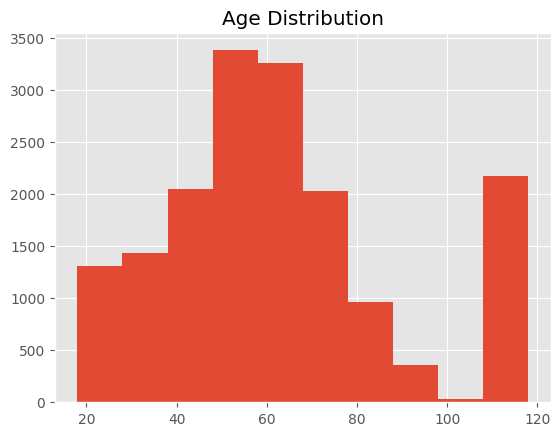

In [ ]:
# Check `age` distribution
#plt.figure(figsize=(17,4))
plt.hist(profile.age)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Income Distribution')

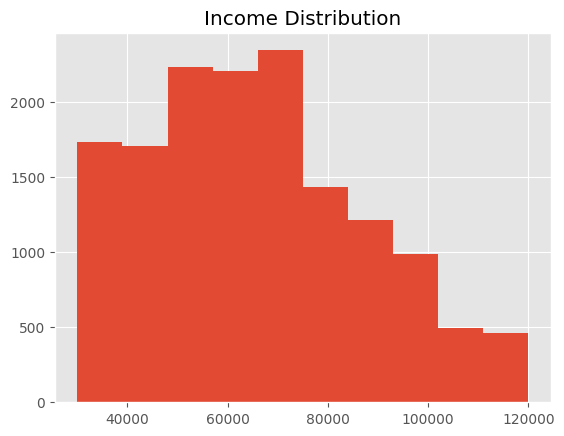

In [ ]:
# Check `income` distribution
plt.hist(profile.income.dropna())
plt.title('Income Distribution')


Text(0.5, 1.0, 'Gender Distribution')

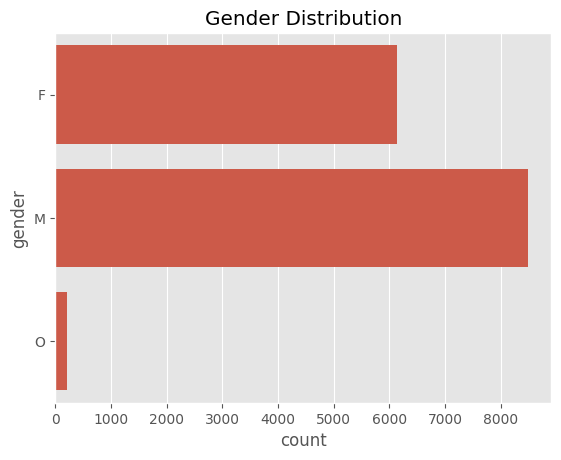

In [ ]:
 sns.countplot(profile.gender)
 plt.title('Gender Distribution')

In [ ]:
profile.gender.value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

**Inference:**

This dataset contains demographic data about members enrolled in the reward program with self-explanatory features. There are 17,000 rows (representing 17,000 customer profiles) and 5 columns. There are 2175 problematic rows with missing values and clear outliers. Aside from that, very little cleaning is required on this dataset

Transcript Dataset
Schema:

* event (str) - record description; transaction, offer received, offer viewed, or offer completed.
* person (str) - customer id.
* time (int) - time in hours since start of test. The data begins at time t=0.
* value - (dict) - either an offer id or transaction amount depending on the record.




In [ ]:
transcript.head()

person           event                                             value  time
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0
2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0
4  68617ca6246f4fbc85e91a2a49552598  offer received  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
transcript.describe()

time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

In [ ]:
transcript.event.value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [ ]:
transcript.loc[transcript.event == 'transaction'].value.head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [ ]:
transcript.loc[transcript.event == 'offer received'].value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [ ]:

transcript.loc[transcript.event == 'offer viewed'].value.head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [ ]:

transcript.loc[transcript.event == 'offer completed'].value.head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

In [ ]:
transcript.loc[transcript.person == '5a8bc65990b245e5a138643cd4eb9837']

Empty DataFrame
Columns: [person, event, value, time]
Index: []

In [ ]:
# Check test period
transcript.time.describe()
print("Test period spans", transcript.time.max() - transcript.time.min(), "hours")
print("Test period in days :",(transcript.time.max() - transcript.time.min())/24,"days")


Test period spans 714 hours
Test period in days : 29.75 days


**Inference:**

This dataset contains records of activities related to the test simulated. Each record is time-stamped since the start of the test. The test start at t=0 and ends at t=714 (≈ 30 days). The nature of each record is described using event. The value column holds a value based on the event column. For offer received, viewed, and completed, the offer id is recorded. For transaction, the amount is recorded. Although this dataset is somehow abstract, 306534 rows and 4 columns, most of the cleaning process will be performed on this dataset.

### Data Cleaning

Portfolio Dataset:

Starting be renaming columns id and reward to offer_id and offered_reward respectively. This serves readability. The latter in particular to make it distinguishable from a later added column redeemed_reward.

In [ ]:
# Rename specified columns
portfolio.rename(columns={
    'id': 'offer_id',
    'reward': 'offered_reward'}, inplace=True)
portfolio.offer_type.value_counts()

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

One-hot encoding for columns channels and offer_type using user defined function one_hot_encoder.

In [ ]:
def one_hot_encoder(df, target_column, categories, prefix):
    '''
    Encode categorical features as a one-hot numeric array with the
    extra ability to handle list values

    '''

    # Create new column for each category and get binary values for each row
    # by searching for that category in target_column
    for i in categories:
        df[f'{prefix}_{i}'] = df[target_column].apply(lambda x: 1 if i in x else 0)

    # Drop target_column
    df = df.drop(target_column,axis=1)

    return df





In [ ]:
# One-hot encode `channel` column
portfolio = one_hot_encoder(
    df = portfolio,
    target_column = 'channels',
    categories = ['web','email','mobile','social'],
    prefix = 'channel')

# One-hot encode `offer_type` column
portfolio = one_hot_encoder(
    df = portfolio,
    target_column = 'offer_type',
    categories = ['discount','bogo','informational'],
    prefix = 'type')

In [ ]:
def label_encoder(df, target_column, start=0, step=1):
    '''
    Encode labels in target_column with numeric values between 'start'
    and n_labels-1 at a specified 'step'

    '''

    # Instantiate dictionary object to store numeric values for each label
    labels_dict = dict()

    # Loop over labels and encode with numeric values
    for label in df[target_column]:
        if label not in labels_dict:
            labels_dict[label] = start
            start += step

    # Map label keys in `target_column` with their values in `labels_dict`
    df[target_column] = df[target_column].apply(lambda x: labels_dict[x])

    return df, labels_dict

In [ ]:
# Convert `offer_id` to integers
portfolio, offer_id_dict = label_encoder(
    df = portfolio,
    target_column = 'offer_id',
    start = 1,
    step = 1)

In [ ]:
offer_id_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

In [ ]:
portfolio.head()

offered_reward  difficulty  duration  offer_id  channel_web  channel_email  channel_mobile  channel_social  type_discount  type_bogo  type_informational
0              10          10         7         1            0              1               1               1              0          1                   0
1              10          10         5         2            1              1               1               1              0          1                   0
2               0           0         4         3            1              1               1               0              0          0                   1
3               5           5         7         4            1              1               1               0              0          1                   0
4               5          20        10         5            1              1               0               0              1          0                   0

In [ ]:
portfolio.isnull().sum()

offered_reward        0
difficulty            0
duration              0
offer_id              0
channel_web           0
channel_email         0
channel_mobile        0
channel_social        0
type_discount         0
type_bogo             0
type_informational    0
dtype: int64

Profile Dataset:

Rename id column to customer_id

In [ ]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

Convert became_member_on column to standard datetime object. This will be used then to add calculated days_member column and then dropped.

In [ ]:
# Convert `became_member_on` to standard `datetime` object
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

# Add calculated 'days_member' column
profile['days_member'] = (pd.to_datetime('today') - profile['became_member_on']).dt.days

# Drop `became_member_on`
profile.drop(columns='became_member_on', inplace=True)

In regards to the 2175 profiles with missing values discussed earlier, the decision was to simply drop them. Also, dropping 212 profiles with 'other' gender. This to make it much easier to just remap 'male' and 'female' gender with binary values in one column. It's important to retain their ids in order to later remove corresponding activies in transcript.

In [ ]:
# Retain `customer_id` of rows to be deleted to later remove corresponding rows in `transcript`
dropped_profiles = profile[
    (profile.gender.isnull() == True) | (profile.gender == 'O')].customer_id.values

# Drop rows using the list produced in `dropped_profiles` above
profile.drop(profile[profile.customer_id.isin(dropped_profiles) == True].index, inplace=True)

# Reset index
profile.reset_index(drop=True, inplace=True)

Now gender column can be simply remapped using binary values.

In [ ]:
# Remap `gender` column using binary values
profile.gender = profile.gender.map({'F':0, 'M':1})

Convert customer_id to integers, again for readability, while retaining the mapping dictionary later used to map customer ids in transcript. All done with help of utility function label_encoder.

In [ ]:
# Convert `customer_id` to integers
profile, customer_id_dict = label_encoder(
    df = profile,
    target_column = 'customer_id',
    start = 1,
    step = 1)

In [ ]:
# Preview 5 element
list(customer_id_dict.items())[0:5]

[('0610b486422d4921ae7d2bf64640c50b', 1),
 ('78afa995795e4d85b5d9ceeca43f5fef', 2),
 ('e2127556f4f64592b11af22de27a7932', 3),
 ('389bc3fa690240e798340f5a15918d5c', 4),
 ('2eeac8d8feae4a8cad5a6af0499a211d', 5)]

In [ ]:
profile.head()

gender  age  customer_id    income  days_member
0       0   55            1  112000.0         2515
1       0   75            2  100000.0         2582
2       1   68            3   70000.0         2230
3       1   65            4   53000.0         2306
4       1   58            5   51000.0         2396

In [ ]:
profile.isnull().sum()

gender         0
age            0
customer_id    0
income         0
days_member    0
dtype: int64

Transcript Dataset:

Rename person column to customer_id

In [ ]:
# Rename `person` column to `customer_id`
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

Drop rows with customer_id corresponding to deleted users in profile.

In [ ]:
# Drop rows with `customer_id` corresponding to deleted users in `profile`
transcript = transcript[transcript.customer_id.isin(dropped_profiles) == False]

Map customer_id with previously created customer_id_dict

In [ ]:
# Map `customer_id` with previously created `customer_id_dict`
transcript.customer_id = transcript.customer_id.apply(lambda x: customer_id_dict[x])


To deal with value column, two new columns are created. value_type and actual_value. Their entries are derived by applying a function along each row to extract and hence separate data. Original value column is then dropped.

In [ ]:
# Add column `value_type`
transcript['value_type'] = transcript.value.apply(lambda x : list(x.keys())[0])

# Add column `actual_value`
transcript['actual_value'] = transcript.value.apply(lambda x : list(x.values())[0])

# Drop `value` column
transcript.drop(columns='value', inplace=True)


In [ ]:
transcript.head(5)

customer_id           event  time value_type                      actual_value
0            2  offer received     0   offer id  9b98b8c7a33c4b65b9aebfe6a799e6d9
2            3  offer received     0   offer id  2906b810c7d4411798c6938adc9daaa5
5            4  offer received     0   offer id  f19421c1d4aa40978ebb69ca19b0e20d
7            5  offer received     0   offer id  3f207df678b143eea3cee63160fa8bed
8            6  offer received     0   offer id  0b1e1539f2cc45b7b9fa7c272da2e1d7

Split transcript dataset into offers and transactions to work on each separately.

In [ ]:
# Split `transcript` dataset into offer and transaction
offers_df = transcript[transcript['event'] != 'transaction']
transactions_df = transcript[transcript['event'] == 'transaction']

Now, column actual_value can be renamed in each dataframe accordingly. In offers_df will be renamed to offer_id, and in transactions_df will be renamed to amount.

In [ ]:
# Rename columns
offers_df.rename(columns={'actual_value': 'offer_id'}, inplace=True)
transactions_df.rename(columns={'actual_value': 'amount'}, inplace=True)

 Due to this split, some coulmns are no longer needed. value_type in offers_df. event and value_type in transactions_df. These columns are to be dropped. the value column was separated

In [ ]:
# Drop unnecessary columns
offers_df.drop(columns='value_type', inplace=True)
transactions_df.drop(columns=['value_type', 'event'], inplace=True)

Now, it is possible to map offer_id in offers_df with previously created offer_id_dict.

In [ ]:
# Map `offer_id` with previously created `offer_id_dict`
offers_df.offer_id = offers_df.offer_id.apply(lambda x: offer_id_dict[x])

In [ ]:
offers_df.head()

customer_id           event  time  offer_id
0            2  offer received     0         4
2            3  offer received     0        10
5            4  offer received     0         9
7            5  offer received     0         3
8            6  offer received     0         5

In [ ]:
offers_df.isnull().sum()

customer_id    0
event          0
time           0
offer_id       0
dtype: int64

In [ ]:
transactions_df.head()

customer_id  time amount
12654           28     0   0.83
12657           39     0  34.56
12659           45     0  13.23
12670          107     0  19.51
12671          123     0  18.97

In [ ]:
transactions_df.isnull().sum()

customer_id    0
time           0
amount         0
dtype: int64

## Data Preprocessing
Now that the four dataframes, portfolio, profile, offers_df, and transactions_df are cleaned. The process of merging and aggregating data can proceed.

The first step is merge portfolio to offers_df.

In [ ]:
# Merge `portfolio` to `offers_df`
offers_df = pd.merge(offers_df, portfolio, on='offer_id')



In [ ]:
offers_df.head()

customer_id           event  time  offer_id  offered_reward  difficulty  duration  channel_web  channel_email  channel_mobile  channel_social  type_discount  type_bogo  type_informational
0            2  offer received     0         4               5           5         7            1              1               1               0              0          1                   0
1           19  offer received     0         4               5           5         7            1              1               1               0              0          1                   0
2           23  offer received     0         4               5           5         7            1              1               1               0              0          1                   0
3           29  offer received     0         4               5           5         7            1              1               1               0              0          1                   0
4           32  offer received     0         4               5           5         7            1              1               1               0              0          1                   0

Three dataframes are then created based on event.

In [ ]:
# Split `offers_df` based on `event`
received_df = offers_df[offers_df['event']=='offer received']
viewed_df = offers_df[offers_df['event']=='offer viewed']
completed_df = offers_df[offers_df['event']=='offer completed']

To keep things clean, new auxiliary dataframe aux_df is created as a copy of received_df which will be the workspace for all preprocessing steps. Many of the columns created in this dataframe will not make it to the final dataframe grouped by customer profiles but they are useful in logical operations.

In [ ]:
# Create aux_df: a copy of received_df
aux_df = received_df.copy()

Since aux_df is nothing but a copy of received_df. Simply the event column which only contains the value ‘offer_recieved’ can be renamed to offer_recieved with a value of 1.

In [ ]:
# Rename `event` to `offer_received` in `aux_df`
aux_df.rename(columns={'event': 'offer_received'}, inplace=True)
aux_df.offer_received = 1

In aux_df, two new columns will serve as the base for all logical tests later. offer_start_time which is nothing but the already existing time column. Hence, time will be renamed to offer_start_time. The other one is offer_end_time which can be easily obtained by adding the offer duratin (in hours) to offer_start_time.

In [ ]:
# Rename `time` to `offer_start_time` and add `offer_end_time`
aux_df.rename(columns={'time': 'offer_start_time'}, inplace=True)
aux_df['offer_end_time'] = aux_df.offer_start_time + aux_df.duration * 24

Now that the start and end time for each offer received in aux_df are present, a user defined function , **get_offer_engagements** will be applied along each row.




This function takes other dataframes ***(viewed_df, completed_df, transactions_df) ***and extract necessary data. The function then returns a list in the form of:


 **[offer_viewed_time,** **offer_completed_time].**


If any was missing or invaild,**returns NaN** in its corresponding place inside the list.





Then, another user defined function **expand_list_to_columns** is used to expand the output value returnd into separate columns.


It is important here to go over the assumption programmed into the function get_offer_engagements for a view or completion time to be valid.


An offer is considered viewed only if done so after it has been received and during offer's duration. That means the conditions for a valid view time:


1. offer_viewed_time >= offer_start_time, and
2. offer_viewed_time <= offer_end_time


An offer is considered completed depending on the offer type:




**For bogo and discount offers,** completed_df dataframe is used extract necessary info.

The completion time must be after the time it has been viewed and during offer's duration.
That means the conditions for a valid complete time in this case:

1. offer_completed_time >= offer_viewed_time, and

2. offer_completed_time <= offer_end_time






**For informational offers,** transactions_df is used to extract necessary info. The way completion for informational offers is measured is by checking if the customer has made any transaction after viewing the offer and in offer's duration which assumed earlier to be the period of influence.

That means the conditions for a valid complete time in this case:

1. transaction_time >= offer_viewed_time, and

2. transaction_time <= offer_end_time

In [ ]:
def get_offer_engagements(aux_df, viewed_df, completed_df, transactions_df):
    '''
    Used inside pd.apply() along columns axis to extract for each offer (row)
    viewing and completion times from relevant input dataframes based on programmed
    logic then for each offer (row) return output_value of list type in the form
    [offer_viewed_time, offer_completed_time] with NaN inplace of any invaild element

    Args:
    aux_df (pd.DataFrame): subject dataframe containing received offers records
    viewed_df, completed_df (pd.DataFrame): input dataframes containing only
        records of viewed and completed offers respectively originating
        from `offers_df` split based on event type
    transactions_df (pd.DataFrame): input dataframe containing only
        transactions originating from `transcript` split based on value type

    Return:
    output_value (list): [offer_viewed_time, offer_completed_time] with NaN
        inplace of any invaild element based on programmed logic
    '''

    # Identify record parameters
    customer_id = aux_df['customer_id']
    offer_id = aux_df['offer_id']
    offer_start_time = aux_df['offer_start_time']
    offer_end_time = aux_df['offer_end_time']


    # PART A -- Get offer_viewed_time

    # Get view time from `viewed_df`
    viewed_time_list = viewed_df.loc[
        # Lookup the identified record
        (viewed_df['customer_id'] == customer_id) &
        (viewed_df['offer_id'] == offer_id) &
        # Assess view time is in duration
        (viewed_df['time'] >= offer_start_time) &
        (viewed_df['time'] <= offer_end_time)
    ]['time'].tolist()

    # Store view time if available in list else return NaN
    offer_viewed_time = np.NaN if not viewed_time_list else viewed_time_list[0]


    # PART B -- Get offer_completed_time

    # Get `time` from `completed_df` if offer is "bogo" or "disc"
    if aux_df['type_informational'] == 0:
        completed_time_list = completed_df.loc[
            # Lookup the identified record
            (completed_df['customer_id'] == customer_id) &
            (completed_df['offer_id'] == offer_id) &
            # Assess completion time is after view and in duration
            (completed_df['time'] >= offer_viewed_time) &
            (completed_df['time'] <= offer_end_time )
        ]['time'].tolist()

    # Get `time` from `transactions_df` if offer is "info"
    if aux_df['type_informational'] == 1:

        # Get 'time' for all customer transactions
        customer_transactions = transactions_df.loc[
            (transactions_df.customer_id == customer_id)
        ]['time'].tolist()

        # Instantiate list
        completed_time_list = []

        for transaction_time in customer_transactions:
            # Assess transaction time is after view and in duration
            if ((transaction_time >= offer_viewed_time) &
                (transaction_time <= offer_end_time)):
                completed_time_list.append(transaction_time)

    # Store completion time if available in list else return NaN
    offer_completed_time = np.NaN if not completed_time_list else completed_time_list[0]


    # Create return object
    output_value = [offer_viewed_time, offer_completed_time]

    return output_value

In [ ]:
def expand_list_to_columns(df, target_column, column_labels):
    '''
    Expand an array of lists identical in length into separate columns

    Args:
    df (pd.DataFrame): subject dataframe
    target_column (str): subject column with an array of lists to be expanded
    column_labels (dict): labels for new columns as dictionary values in same
        order of list elements where keys start from 0 until n_elements-1

    Return:
    df (pd.DataFrame): copy of subject dataframe with list elements in each row
        of target_column expanded into separate columns

    '''

    # Split list elements into columns and merge back to original dataframe
    df = df[target_column].apply(pd.Series).merge(df, left_index=True, right_index=True)

    # Rename columns as per `column_labels`
    df = df.rename(columns=column_labels)

    # Drop `target_column`
    df = df.drop(columns=target_column)

    return df

In [ ]:
# Add empty object column to store `output_value` list of function
aux_df['output_value'] = ''

# Apply u.get_offer_engagements to each row
aux_df.output_value = aux_df.apply(
    lambda x: get_offer_engagements(x, viewed_df, completed_df, transactions_df), axis=1)

# Expand `output_value` list to columns
aux_df = expand_list_to_columns(aux_df, 'output_value', {
    0: 'offer_viewed_time',
    1: 'offer_completed_time'})

In [ ]:
aux_df[['offer_start_time', 'offer_end_time', 'offer_viewed_time', 'offer_completed_time']].head()

offer_start_time  offer_end_time  offer_viewed_time  offer_completed_time
0                 0             168                6.0                 132.0
1                 0             168                NaN                   NaN
2                 0             168               48.0                   NaN
3                 0             168               30.0                  66.0
4                 0             168                NaN                   NaN

One feature that will be added is response_score which measures how fast a customer responded to an offer once viewed. The score is normalized using offer's duration and range from 0 to 1. The higher the score, the faster responsivity to an offer.

In [ ]:
# Add `response_score` column

aux_df['response_score'] = (
    aux_df.offer_completed_time -
    aux_df.offer_viewed_time).apply(
    lambda x: x if x >= 0 else np.NaN)

aux_df.response_score = np.round(((
    (aux_df.duration * 24) - aux_df.response_score) /
    (aux_df.duration * 24)), 2).fillna(0)

In [ ]:
aux_df[['offer_viewed_time', 'offer_completed_time', 'response_score']].head()

offer_viewed_time  offer_completed_time  response_score
0                6.0                 132.0            0.25
1                NaN                   NaN            0.00
2               48.0                   NaN            0.00
3               30.0                  66.0            0.79
4                NaN                   NaN            0.00

<Axes: >

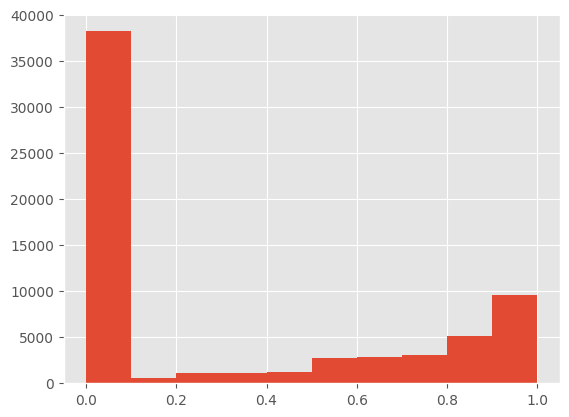

In [ ]:
aux_df.response_score.hist()

Since the view and compeltion time is now present, two new columns offer_viewed and offer_completed with binery values will be added.

In [ ]:
# Add `offer_viewed` and `offer_completed` columns with binery values
aux_df['offer_viewed'] = aux_df.offer_viewed_time.apply(lambda x: 0 if pd.isnull(x) else 1)
aux_df['offer_completed'] = aux_df.offer_completed_time.apply(lambda x: 0 if pd.isnull(x) else 1)

In [ ]:
aux_df[['offer_viewed_time', 'offer_completed_time', 'offer_viewed', 'offer_completed']].head()


offer_viewed_time  offer_completed_time  offer_viewed  offer_completed
0                6.0                 132.0             1                1
1                NaN                   NaN             0                0
2               48.0                   NaN             1                0
3               30.0                  66.0             1                1
4                NaN                   NaN             0                0

New redeemed_reward columns is added by simply multiplying offered_reward by offer_completed.

In [ ]:
# Add `redeemed_reward` columns
aux_df['redeemed_reward'] = aux_df.offered_reward * aux_df.offer_completed


To make things clean, three temprary (dummy) dataframes are created. Named alpha_df, beta_df, and gamma_df. In the first two, selection of columns are used and aggregated by sum and mean respectively. In the last, utility function split_columns_by_offer_type is used on a selection of columns to aggregate data by offer type.

In [ ]:
def split_columns_by_offer_type(df, target_columns):
    '''
    Split any giving columns by offer type (bogo, disc, info) and return
    new dataframe of only passed target_columns with `customer_id` as index

    Args:
    df (pd.DataFrame): subject dataframe
    target_columns (list): subject columns labels to splitted by offer type

    Return:
    output_df (pd.DataFrame): new dataframe with only passed target_columns
        splitted by offer type and `customer_id` as index
    '''

    # Create auxiliary list with `Grouper` columns
    aux_columns_list = ['customer_id', 'offer_id']

    # Append input `target_columns` to `aux_columns_list`
    for column in target_columns:
        aux_columns_list.append(column)

    # Create auxiliary dataframe pivoted by
    # `customer_id` as Grouper index and `offer_id` as Grouper columns
    aux_df = pd.pivot_table(
        df[aux_columns_list],
        index='customer_id', columns='offer_id',
        fill_value=0, aggfunc='mean')

    # Flatten multilevel column labels with suffix identifying offer_id (oid)
    aux_df.columns = aux_df.columns.map('{0[0]}_oid_{0[1]}'.format)

    # Create lists and store offer_id based on type (obtained from portfolio)
    bogo_oids = [1,2,4,9]
    disc_oids = [5,6,7,10]
    info_oids = [3,8]

    # Create output dataframe
    output_df = pd.DataFrame()

    for column in target_columns:

        # Instantiate variables to hold computations
        bogo_value = 0
        disc_value = 0
        info_value = 0

        # Compute for each offer type its value
        for i in bogo_oids:
            bogo_value += aux_df[f'{column}_oid_{i}']

        for i in disc_oids:
            disc_value += aux_df[f'{column}_oid_{i}']

        for i in info_oids:
            info_value += aux_df[f'{column}_oid_{i}']

        # Store computed values in relevant columns
        output_df[f'bogo_{column}'] = bogo_value
        output_df[f'disc_{column}'] = disc_value
        output_df[f'info_{column}'] = info_value

    return output_df


In [ ]:
# Create dummy dataframes each with different selection of columns and aggregator

alpha_df = aux_df[[
    'customer_id',
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'channel_web',
    'channel_email',
    'channel_mobile',
    'channel_social',
    ]].groupby('customer_id', as_index=True).sum().fillna(0)

beta_df = aux_df[[
    'customer_id',
    'difficulty',
    'duration',
    'offered_reward',
    'redeemed_reward',
    'response_score',
    ]].groupby('customer_id', as_index=True).mean().fillna(0)

gamma_df = split_columns_by_offer_type(aux_df, [
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'response_score',
    ])

Now, creating the final datframe coe which will be used for modeling by megring the above dataframes alpha_df, beta_df, and gamma_df to profile.

In [ ]:
# Create the final dataset `coe`
coe = pd.merge(profile.set_index('customer_id'), alpha_df, left_index=True, right_index=True)
coe = pd.merge(coe, beta_df, left_index=True, right_index=True)
coe = pd.merge(coe, gamma_df, left_index=True, right_index=True)

coe.reset_index(inplace=True)

In this step below, sets of new features will be added using user defined function get_transactions_allotment that will be helpful. The nomenclature for these features is as follows:

Prefixes

*   txn_: Count of transactions.
*   amt_: Sum of amount.List item




Suffixes


*  _overall: Anytime during the test period.
*  _promo: During offer durations (regardless of view or completion).
*  _nonpromo: In-between (outside) offers durations









In [ ]:
def get_transactions_allotment(df, aux_df, transactions_df):
    '''
    Used inside pd.apply() along columns axis to extract for each customer (row)
    count and amount of overall, promo, and nonpromo transactions ,later then for each customer (row) return output_value of list type in the form
    [txn_overall, amt_overall, txn_promo, amt_promo, txn_nonpromo, amt_nonpromo] with NaN inplace of any invaild element

    Args:
    df (pd.DataFrame): subject dataframe containing records grouped by customers
    aux_df (pd.DataFrame): input dataframe containing received offers records
    transactions_df (pd.DataFrame): input dataframe containing only
        transactions originating from `transcript` split based on value type

    Return:
    output_value (list): [txn_overall, amt_overall, txn_promo, amt_promo,
        txn_nonpromo, amt_nonpromo] with NaN
        inplace of any invaild element based on programmed logic
    '''

    # Identify customer
    customer_id = df['customer_id']

    # Get all transactions 'time' and `amount` for identified customer
    # This cerates list of lists in the form [time, amount]
    customer_transactions = transactions_df.loc[
        (transactions_df.customer_id == customer_id)
    ][['time', 'amount']].values.tolist()

    # Get `offer_start_time` and `offer_end_time` for all offers received
    # This cerates list of lists in the form [offer_start_time, offer_end_time]
    customer_offers = aux_df.loc[
        (aux_df.customer_id == customer_id)
    ][['offer_start_time', 'offer_end_time']].values.tolist()

    # Instantiate list for transactions overall
    overall = []

    # Instantiate list for transactions in promotional periods
    promo = []

    # For each list element in `customer_transactions` list
    for transaction in customer_transactions:
        # Append list element to `overall`
        overall.append(transaction)
        # Get transaction time for logical operation
        txn_time = transaction[0]

        # For each list element in `customer_offers` list
        for offer in customer_offers:
            # Get offer start and end times for logical operation
            offer_start_time = offer[0]
            offer_end_time = offer[1]
            # Assess transaction time during promotional periods and
            # Append list element to `promo`
            if txn_time in range(offer_start_time, offer_end_time + 1):
                promo.append(transaction)


    # PART A -- Get overall, promo, nonpromo transactions

    # Convert `overall` and `promo` to set of tuples
    ''' This serves two purposes:
    (1) Creates a set of unique elements since one transaction can be in
        two or more overlapping offer durations
    (2) Allows creating `nonpromo` by just subtracting other two sets'''
    overall = set(tuple(txn) for txn in overall)
    promo = set(tuple(txn) for txn in promo)
    nonpromo = overall - promo

    # Convert back to list to easily access values
    overall = list(overall)
    promo = list(promo)
    nonpromo = list(nonpromo)

    # Output "overall" transactions:
    # Get count of transactions by getting length of `overall`
    txn_overall = len(overall)
    # Get amount of transactions by summing second elements in `overall`
    amt_overall = np.round(
        sum(overall[i][1] for i in range(len(overall))), 2)

    # Output "promo" transactions:
    # Get count of transactions by getting length of `promo`
    txn_promo = len(promo)
    # Get amount of transactions by summing second elements in `promo`
    amt_promo = np.round(
        sum(promo[i][1] for i in range(len(promo))), 2)

    # Output "nonpromo" transactions:
    # Get count of transactions by getting length of `nonpromo`
    txn_nonpromo = len(nonpromo)
    # Get amount of transactions by summing second elements in `nonpromo`
    amt_nonpromo = np.round(
        sum(nonpromo[i][1] for i in range(len(nonpromo))), 2)


       # Create return object
    output_value = [txn_overall, amt_overall,
                    txn_promo, amt_promo,
                    txn_nonpromo, amt_nonpromo]

    return output_value


In [ ]:
# Add empty object column to store `output_value` list of function
coe['output_value'] = ''

# Apply u.get_transactions_allotment to each row
coe.output_value = coe.apply(
    lambda x: get_transactions_allotment(x, aux_df, transactions_df), axis=1)

# Expand `output_value` list to columns
coe = expand_list_to_columns(coe, 'output_value', {
    0: 'txn_overall',
    1: 'amt_overall',
    2: 'txn_promo',
    3: 'amt_promo',
    4: 'txn_nonpromo',
    5: 'amt_nonpromo'})

Three more features are added:
 1. amt_per_test_hour: avergae spent during the test period per hour,
 2. amt_per_member_day: avergae spent during the test period per number of membrship days
 3. amt_per_income: avergae spent during the test period per income.


In [ ]:
# Add three more calculated columns describing customers attributes
coe['amt_per_test_hour'] = np.round(coe.amt_overall / transactions_df.time.max(), 6)
coe['amt_per_member_day'] = np.round(coe.amt_overall / coe.days_member, 6)
coe['amt_per_income'] = np.round(coe.amt_overall / coe.income, 6)

Final step is to drop customer_id column.

In [ ]:
# Drop 'customer_id' column; not needed in the model
coe.drop(columns='customer_id', inplace=True)

In [ ]:
coe

txn_overall  amt_overall  txn_promo  amt_promo  txn_nonpromo  amt_nonpromo  gender  age    income  days_member  offer_received  offer_viewed  offer_completed  channel_web  channel_email  channel_mobile  channel_social  difficulty  duration  offered_reward  redeemed_reward  response_score  bogo_offer_received  disc_offer_received  info_offer_received  bogo_offer_viewed  disc_offer_viewed  info_offer_viewed  bogo_offer_completed  disc_offer_completed  info_offer_completed  bogo_response_score  disc_response_score  info_response_score  amt_per_test_hour  amt_per_member_day  amt_per_income
0              3.0        77.01        1.0      23.22           2.0         53.79       0   55  112000.0         2515               2             0                0            2              2               2               0    2.500000  5.500000        2.500000         0.000000        0.000000                    1                    0                    1                0.0                0.0                0.0                   0.0                   0.0                   0.0                 0.00                 0.00                 0.00           0.107857            0.030620        0.000688
1              7.0       159.27        6.0     135.34           1.0         23.93       0   75  100000.0         2582               4             4                3            2              4               4               3    5.000000  5.500000        5.000000         3.750000        0.390000                    3                    0                    1                3.0                0.0                1.0                   2.0                   0.0                   1.0                 0.64                 0.00                 0.92           0.223067            0.061685        0.001593
2              3.0        57.73        1.0      18.42           2.0         39.31       1   68   70000.0         2230               4             3                2            4              4               4               1    6.250000  7.000000        2.250000         1.750000        0.347500                    1                    2                    1                1.0                2.0                0.0                   1.0                   1.0                   0.0                 0.39                 1.00                 0.00           0.080854            0.025888        0.000825
3              3.0        36.43        3.0      36.43           0.0          0.00       1   65   53000.0         2306               6             6                5            6              6               6               3    6.666667  6.833333        4.000000         3.166667        0.405000                    2                    2                    0                2.0                2.0                0.0                   1.5                   2.0                   0.0                 0.67                 1.09                 0.00           0.051022            0.015798        0.000687
4              4.0        15.62        4.0      15.62           0.0          0.00       1   58   51000.0         2396               3             2                1            3              3               3               2    5.666667  7.000000        1.666667         0.666667        0.183333                    0                    2                    1                0.0                2.0                0.0                   0.0                   1.0                   0.0                 0.00                 0.55                 0.00           0.021877            0.006519        0.000306
...            ...          ...        ...        ...           ...           ...     ...  ...       ...          ...             ...           ...              ...          ...            ...             ...             ...         ...       ...             ...              ...             ...                  ...                  ...                  ...                ...                ...           

At this point, dataframe coe is ready to be used for modeling to perform customer segmentation. It has 37 features and 14608 samples. All features are numerical except gender which is a categorical feature represented by binary values.

In [ ]:
coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14608 entries, 0 to 14607
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   txn_overall           14608 non-null  float64
 1   amt_overall           14608 non-null  float64
 2   txn_promo             14608 non-null  float64
 3   amt_promo             14608 non-null  float64
 4   txn_nonpromo          14608 non-null  float64
 5   amt_nonpromo          14608 non-null  float64
 6   gender                14608 non-null  int64  
 7   age                   14608 non-null  int64  
 8   income                14608 non-null  float64
 9   days_member           14608 non-null  int64  
 10  offer_received        14608 non-null  int64  
 11  offer_viewed          14608 non-null  int64  
 12  offer_completed       14608 non-null  int64  
 13  channel_web           14608 non-null  int64  
 14  channel_email         14608 non-null  int64  
 15  channel_mobile     

**Schema:**

**txn_overall:** Count of transactions made anytime during the test

**amt_overall:** Sum of amount spent anytime during the test.

**txn_promo:** Count of transactions made during offer durations (regardless of view or completion).

**amt_promo:** Sum of amount spent during offer durations (regardless of view or completion).

**txn_nonpromo:** Count of transactions in-between (outside) offers durations.

**amt_nonpromo:** Sum of amount spent in-between (outside) offers durations.

**gender:** Customer's gender {0: Female, 1:Male}

**age:** Customer's age.

**income:** Customer's income.

**days_member:** Number of days as a member of the program (dynamic; as of today's date).

**offer_received:** Count of total offers received.

**offer_viewed:** Count of total offers viewed.

**offer_completed:** Count of total offers completed.

**channel_web:** Count of total offer received via web.

**channel_email:** Count of total offer received via email.

**channel_mobile:**  Count of total offer received via mobile.

**channel_social:** Count of total offer received via social.

**difficulty:** Average of minimum required to be spent for all offers received.

**duration:** Average of validity period for all offers received.

**offered_reward:** Average of offered reward for all offers received.

**redeemed_reward:** Average of redeemed reward for all offers received.

**response_score:** Average of response score for all offers received.

**bogo_offer_received:** Count of total 'bogo' offers received.

**disc_offer_received:** Count of total 'discount' offers received.

**info_offer_received:** Count of total 'informational' offers received.

**bogo_offer_viewed:** Count of total 'bogo' offers viewed.

**disc_offer_viewed:** Count of total 'discount' offers viewed.

**info_offer_viewed:** Count of total 'informational' offers viewed.

**bogo_offer_completed:** Count of total 'bogo' offers completed.

**disc_offer_completed:** Count of total 'discount' offers completed.

**info_offer_completed:** Count of total 'informational' offers completed.

**bogo_response_score:** Average of response score for all 'bogo' offers received.

**disc_response_score:** Average of response score for all 'discount' offers received.

**info_response_score:** Average of response score for all 'informational' offers received.

**amt_per_test_hour:** Average spend during the test period per hour.

**amt_per_member_day:** Average spend during the test period per day as a member of the program.

**amt_per_income:** Average spend during the test period per income.

In [ ]:
coe.head()

txn_overall  amt_overall  txn_promo  amt_promo  txn_nonpromo  amt_nonpromo  gender  age    income  days_member  offer_received  offer_viewed  offer_completed  channel_web  channel_email  channel_mobile  channel_social  difficulty  duration  offered_reward  redeemed_reward  response_score  bogo_offer_received  disc_offer_received  info_offer_received  bogo_offer_viewed  disc_offer_viewed  info_offer_viewed  bogo_offer_completed  disc_offer_completed  info_offer_completed  bogo_response_score  disc_response_score  info_response_score  amt_per_test_hour  amt_per_member_day  amt_per_income
0          3.0        77.01        1.0      23.22           2.0         53.79       0   55  112000.0         2515               2             0                0            2              2               2               0    2.500000  5.500000        2.500000         0.000000        0.000000                    1                    0                    1                0.0                0.0                0.0                   0.0                   0.0                   0.0                 0.00                 0.00                 0.00           0.107857            0.030620        0.000688
1          7.0       159.27        6.0     135.34           1.0         23.93       0   75  100000.0         2582               4             4                3            2              4               4               3    5.000000  5.500000        5.000000         3.750000        0.390000                    3                    0                    1                3.0                0.0                1.0                   2.0                   0.0                   1.0                 0.64                 0.00                 0.92           0.223067            0.061685        0.001593
2          3.0        57.73        1.0      18.42           2.0         39.31       1   68   70000.0         2230               4             3                2            4              4               4               1    6.250000  7.000000        2.250000         1.750000        0.347500                    1                    2                    1                1.0                2.0                0.0                   1.0                   1.0                   0.0                 0.39                 1.00                 0.00           0.080854            0.025888        0.000825
3          3.0        36.43        3.0      36.43           0.0          0.00       1   65   53000.0         2306               6             6                5            6              6               6               3    6.666667  6.833333        4.000000         3.166667        0.405000                    2                    2                    0                2.0                2.0                0.0                   1.5                   2.0                   0.0                 0.67                 1.09                 0.00           0.051022            0.015798        0.000687
4          4.0        15.62        4.0      15.62           0.0          0.00       1   58   51000.0         2396               3             2                1            3              3               3               2    5.666667  7.000000        1.666667         0.666667        0.183333                    0                    2                    1                0.0                2.0                0.0                   0.0                   1.0                   0.0                 0.00                 0.55                 0.00           0.021877            0.006519        0.000306

In [ ]:
coe.isnull().sum()

txn_overall             0
amt_overall             0
txn_promo               0
amt_promo               0
txn_nonpromo            0
amt_nonpromo            0
gender                  0
age                     0
income                  0
days_member             0
offer_received          0
offer_viewed            0
offer_completed         0
channel_web             0
channel_email           0
channel_mobile          0
channel_social          0
difficulty              0
duration                0
offered_reward          0
redeemed_reward         0
response_score          0
bogo_offer_received     0
disc_offer_received     0
info_offer_received     0
bogo_offer_viewed       0
disc_offer_viewed       0
info_offer_viewed       0
bogo_offer_completed    0
disc_offer_completed    0
info_offer_completed    0
bogo_response_score     0
disc_response_score     0
info_response_score     0
amt_per_test_hour       0
amt_per_member_day      0
amt_per_income          0
dtype: int64

## Modeling & Evaluation
**K-Means** is the choice for this problem, but as a first step, the data will be transformed using PowerTransformer to make data more Gaussian-like while also standardized such that its distribution will have a mean value 0 and standard deviation of 1.

This is important because K-means clustering in particular is “isotropic" in all directions of space and therefore tends to produce round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance.


Another transformation, i.e. dimensionality reduction, will be performed using **Principal Component Analysis (PCA)**. Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

Then before implantation, two substeps are taken:

Finding optimal number of clusters using silhouette and elbow methods. This can be easily achieved using utility function plot_optimization_analysis to plot scores for clusters ranging between 2 and 30. The function takes argument sample size which is randomly selected from the original data to reduce computational cost.

Performing Silhouette Analysis using utility function plot_silhouette_analysis. In silhouette analysis plots, the focus is on three criteria; misclassified points (score < 0) be minimum as possible, clusters plot should be above the average value as much as possible (meaning most of the points are above the silhouette average as any region below is undesirable), and clusters plot width (points distribution in clusters) should be as uniform as possible.

## Feature Transformation and Dimensionality Reduction

In [ ]:
# Apply PowerTransformer and PCA to data

# Instantiate transformers object
est = PowerTransformer()
pca = PCA()

# Store transformation result in dataframe
coe_pca = pd.DataFrame(
    pca.fit_transform(est.fit_transform(coe)),
    columns=coe.columns, index=coe.index)

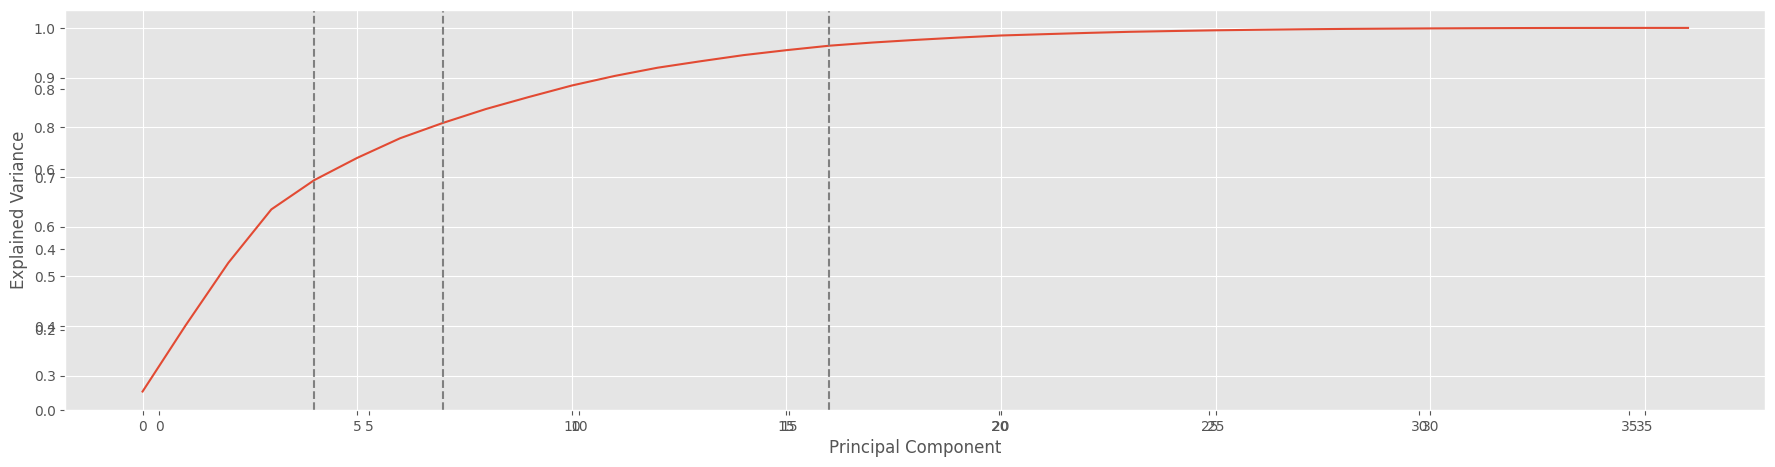

Minimum n_components required for 55% explained variance: 4
Minimum n_components required for 75% explained variance: 7
Minimum n_components required for 95% explained variance: 16


In [ ]:
# Investigate the variance accounted for by each principal component

fig = plt.figure(figsize=(17,4))

ax1 = fig.add_axes([0,0,1,1])
ax1.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

ax2 = fig.add_axes([0,0,1,1])
ax2.plot(np.cumsum(pca.explained_variance_ratio_))

ev_list = [0.55, 0.75, 0.95]
n_components_list = []

for ev in ev_list:
    n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>ev)[0]+1)
    ax1.axhline(ev, linestyle='dashed', color='grey')
    ax2.axvline(n_components, linestyle='dashed', color='grey')
    n_components_list.append(n_components)

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.show()

for ev, nc in zip(ev_list, n_components_list):
    print(f'Minimum n_components required for {int(ev*100)}% explained variance: {nc}')

The aim here is use a sufficient percentage to capture the majority of the variability in the data while keeping number of principal components reasonably small. In this particular case, since the original dataframe has only 37 features which in itself is small, 95% explained variance will be used.

In [ ]:
#eigen vectors
pca.components_

NameError: name 'pca' is not defined

In [ ]:
def plot_pca_component(df, pca, component, n_features=5):
    '''
    Plot top n_features head and tail weights of PCA() class
    with each weight mapped to their corresponding column label

    Args:
    df (pd.DataFrame): subject dataframe
    pca (class): PCA()
    component (int): index of `n_components` to investigate
    n_features (int) [default=5]: top head and tail weights to plot

    Return:
    None
    '''

    # Get sorted weights for specified `component` by fisrt creating
    # dataframe with all components and mapped column labels
    weights = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[
        component].sort_values(ascending=False)

    # Create auxiliary dataframe with head and tail n_features and plot them
    aux_df = pd.concat([weights.head(n_features), weights.tail(n_features)])
    plt.figure(figsize=(17,4))
    aux_df.plot(kind='barh', title=f'Principal Component {component}')
    ax = plt.gca()
    ax.set_xlabel('Weight')

    # Show output
    plt.show()

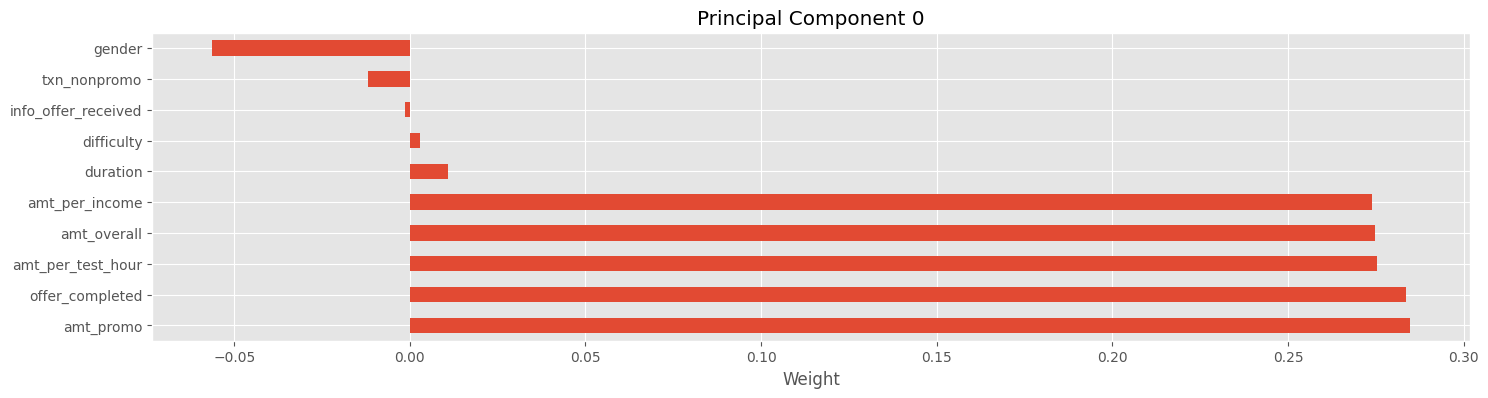

In [ ]:
# Investigate the first principal component
plot_pca_component(coe, pca, 0)

The first principal component is associated largely with features in relation to customer's gender, amount spent in promotional durations, number offer completed, and also avengers spent per test hour and per income.


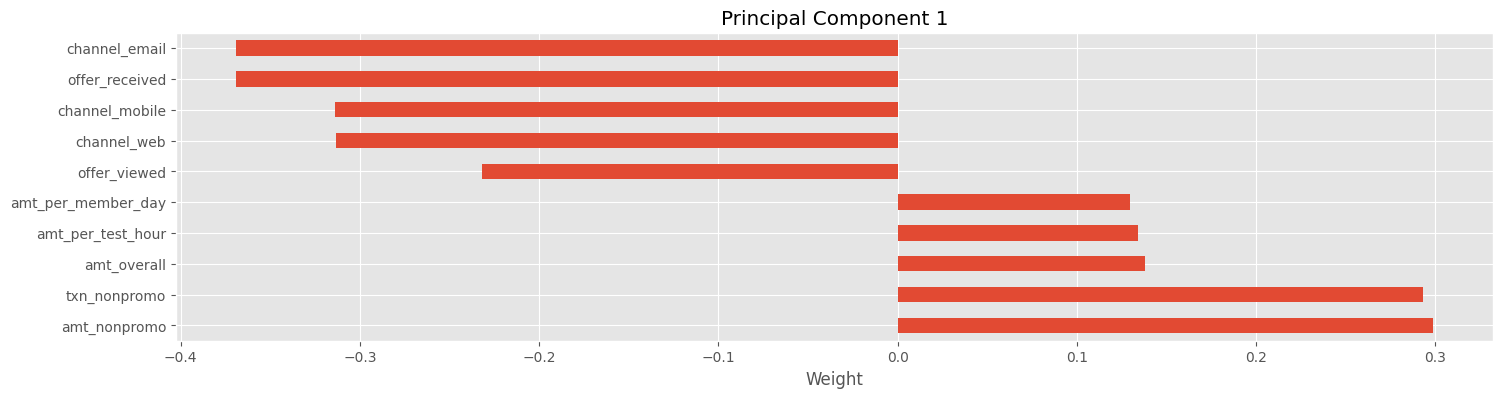

In [ ]:
plot_pca_component(coe, pca, 1)

The second principal component is largely associated with total number of offer received by a customer and their communication channels. Also, puts a lot of weight on activities outside of promotional durations.

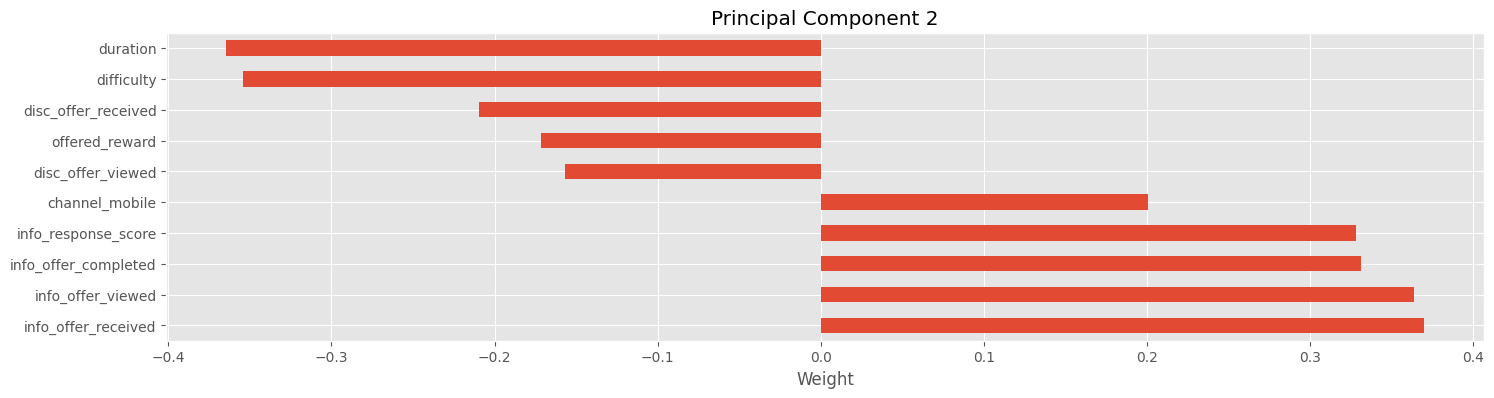

In [ ]:
# Investigate the third principal component
plot_pca_component(coe, pca, 2)

The third principal component is largely associated with averages of duration and difficulty. Also with 'informational' offers features.


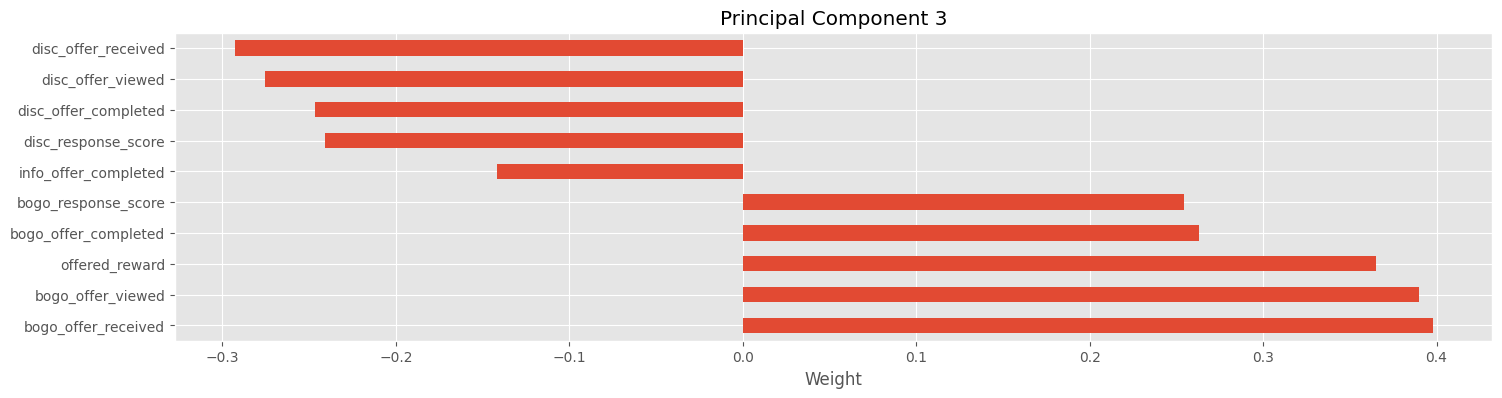

In [ ]:
# Investigate the fourth principal component
plot_pca_component(coe, pca, 3)

The fourth principal component is largely associated with 'bogo' and 'discount' offers features.

## Modeling & Evaluation

Finding Optimal Number of Clusters

In [ ]:
def transform_data(df, ev, tsne=False):
    '''
    Apply PowerTransformer(), PCA(), and optionally TSNE() sequentially on dataframe

    Args:
    df (pd.DataFrame): subject dataframe
    ev : explained variance correspond to `n_components`
        parameter in PCA() class and hence inherits its arguments
    tsne (bool) [default=False]: When True, apply TSNE() on dataframe

    Return:
    X (array): transformed dataframe
    '''

    X = PCA(ev, random_state=42).fit_transform(PowerTransformer().fit_transform(df))

    if tsne == True:
        perplexity = int(X.shape[0] ** 0.5)
        X = TSNE(perplexity=perplexity, random_state=42).fit_transform(X)

    return X

In [ ]:
def fit_predict_data(X, n_clusters, est='KMeans'):
    '''
    Estimate model parameters and predict labels for input X array

    Args:
    X (array): input data
    n_clusters (int): number of clusters to form
    est (str) [default='KMeans']: estimator to use; 'KMeans' or 'GaussianMixture'

    Return:
    model (self): fitted estimator
    labels (array): cluster labels
    '''

    est_dict = {
        'KMeans': KMeans(n_clusters, random_state=42),
        'GaussianMixture': GaussianMixture(n_clusters, random_state=42)}

    model = est_dict[est]
    labels = model.fit_predict(X)

    return model, labels


In [ ]:
def plot_optimization_analysis(df, ev, est='KMeans', tsne=False, sample_size=0.05):
    '''
    Plot change across number of clusters ranging between 2 and 30 clusters in
    average silhouette score and sum of squared errors when est is 'KMeans'
    or 4 trials in average silhouette score when est is `GaussianMixture`

    Args:
    df (pd.DataFrame): subject dataframe
    ev (int, float, None, str): explained variance correspond to `n_components`
        parameter in PCA() class and hence inherits its arguments
    est (str) [default='KMeans']: estimator to use; 'KMeans' or 'GaussianMixture'
    tsne (bool) [default=False]: When True, apply TSNE() on dataframe
    sample_size (float) [default=0.05] = size of randomly selected sample

    Return:
    None
    '''


    # Apply transformations to data
    X = transform_data(df, ev, tsne)

    # Create clusters range list
    n_clusters = list(range(2, 31))

    # Plot for 'KMeans' est
    if est == 'KMeans':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

        # Select random sample
        sample = X[np.random.choice(
            X.shape[0], int(X.shape[0] * sample_size), replace=False)]

        # Instantiate lists to store scores across clusters range
        sil_scores = []
        sse_scores = []

        # For each `n_clusters`; fit model, predict labels, append scores
        for i in n_clusters:
            model, labels = fit_predict_data(sample, i, est)
            sil_scores.append(silhouette_score(sample, labels))
            sse_scores.append(np.abs(model.score(X)))

        # Plot change in silhouette average (silhouette method)
        ax1.plot(n_clusters, sil_scores, linestyle='-', marker='o')
        ax1.locator_params(axis='x', nbins=31)
        ax1.set_title('Silhouette Method')
        ax1.set_xlabel('Clusters')
        ax1.set_ylabel('Silhouette Score')

        # Plot chnage in SSE to apply elbow method
        ax2.plot(n_clusters, sse_scores, linestyle='-', marker='o')
        ax2.locator_params(axis='x', nbins=31)
        ax2.set_title('Elbow Method')
        ax2.set_xlabel('Clusters')
        ax2.set_ylabel('Sum of Squared Errors')

        # Set `transformers`; to be used in plot suptitle adjunct text
        transformers = 'PowerTransformer -> PCA'

       fig.tight_layout()

    # Add suptitle and adjunct text
    fig.suptitle(f'Optimal Clusters Analysis for {est} Clustering', size=17)
    fig.subplots_adjust(top=0.86)
    fig.text(0.5, 0.92,
             f'Transformers: {transformers} | PCA EV: {ev} | Sample Size: {sample_size}',
             ha='center',
             size=14)

    # Show output
    plt.show()

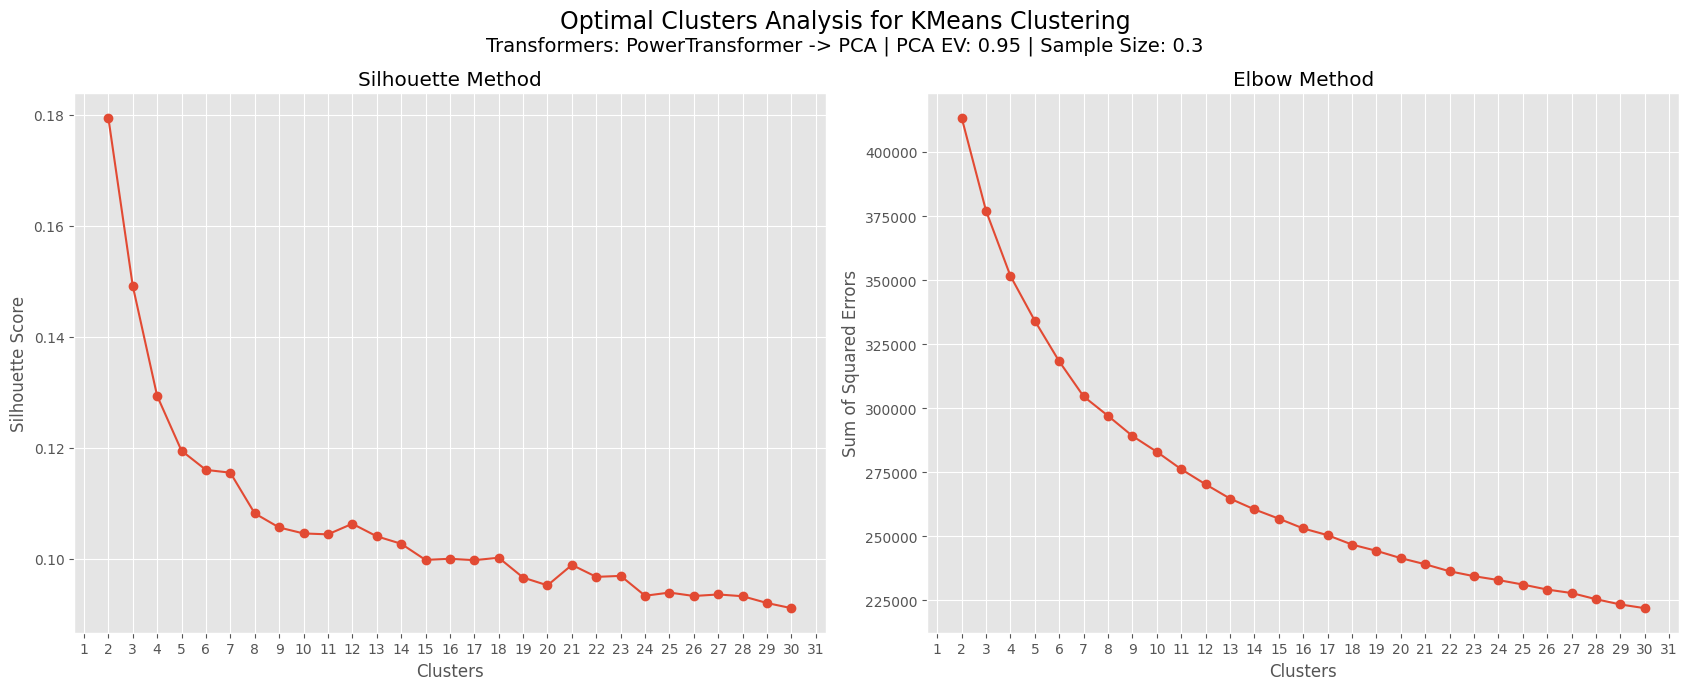

In [ ]:
# Investigate change in SC and SSE across number of clusters
plot_optimization_analysis(
    df = coe,
    ev = 0.95,
    sample_size = 0.3)

First and foremost, the silhouette score is rather low indicating overlapping clusters (indifferent). The “elbow” method is not helpful in this case since there is no clear “elbow”. The silhouette method can be followed rigorously and thus making 2-3 the optimal number of clusters, or a compromise between the two methods can followed leading to an optimal number of 4-7 clusters.

## Performing Silhouette Analysis

In [ ]:
def plot_silhouette_analysis(df, ev, n_clusters, est='KMeans', tsne=False):
    '''
    Plot silhouette plot and feature space plot on two-columns axes

    Code in this function is obtained from scikit-learn example code
    titled "plot_kmeans_silhouette_analysis" with some minor changes
    scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    Args:
    df (pd.DataFrame): subject dataframe
    ev (int, float, None, str): explained variance correspond to `n_components`
        parameter in PCA() class and hence inherits its arguments
    n_clusters (int): number of clusters to form
    est (str) [default='KMeans']: estimator to use; 'KMeans' or 'GaussianMixture'
    tsne (bool) [default=False]: When True, apply TSNE() on dataframe

    Return:
    None
    '''

    # Apply transformations to data
    X = transform_data(df, ev, tsne)

    # fit model, predict labels, and append overall average
    # score and silhouette score for each sample
    model, labels = fit_predict_data(X, n_clusters, est)
    sil_score = silhouette_score(X, labels)
    sil_sample = silhouette_samples(X, labels)

    # Create subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))


    # Part A -- silhouette plot

    # Set appropriate limits for x-axis and y-axis
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Get aggregated sorted silhouette scores for samples
        ith_cluster_silhouette_values = sil_sample[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

        # Label silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), color = 'black', fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

        # Compute new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title('Cluster Silhouette Plot')
    ax1.set_xlabel('Silhouette Coefficient')
    ax1.set_ylabel('Cluster')

    # Plot vertical line for overall average silhouette score
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    # Set appropriate ticks for x-axis and y-axis
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # Part B -- feature space plot

    # Plot 1st and 2nd feature space
    colors = cm.Spectral(labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, c=colors)

    # Set `transformers`; to be used in plot suptitle adjunct text
    transformers = 'PowerTransformer -> PCA -> TSNE'

    # Illuminate cluster centers if est is 'KMeans'
    if est == 'KMeans':
        centers = model.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", s=300, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        # Set `transformers`; to be used in plot suptitle adjunct text
        transformers = 'PowerTransformer -> PCA'

    ax2.set_title('Cluster Feature Space Plot')
    ax2.set_xlabel('1st Feature')
    ax2.set_ylabel('2nd Feature')

    fig.tight_layout()

    # Add suptitle and adjunct text
    plt.suptitle((f'Silhouette Analysis for {est} Clustering'), size=17)
    fig.subplots_adjust(top=0.86)
    fig.text(0.5, 0.92,
             f'Transformers: {transformers} - PCA: {ev} - n_clusters: {n_clusters}',
             ha='center',
             size=14)

    # Show output
    plt.show()


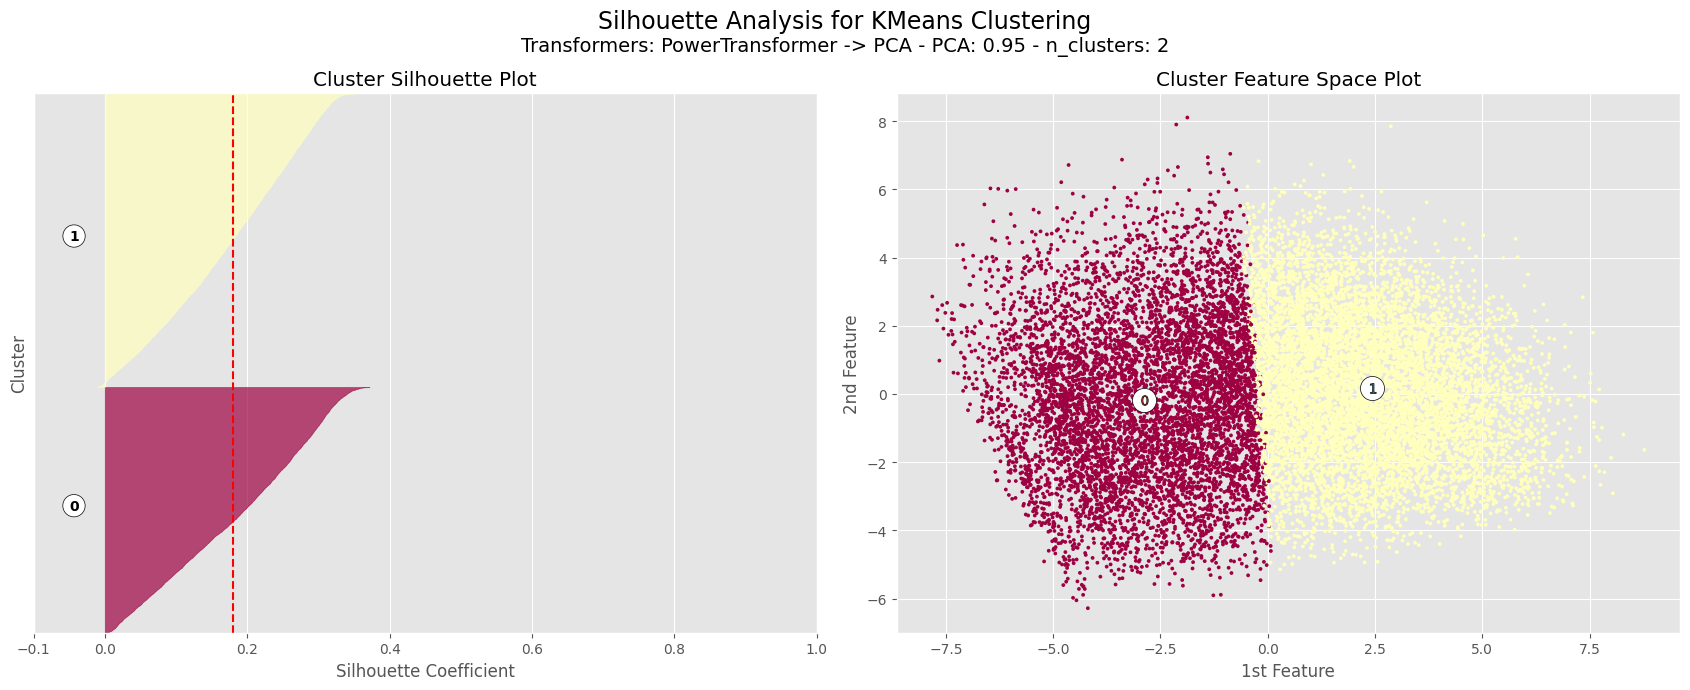

In [ ]:
# Investigate silhouette analysis plot with n_clusters=2
plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 2)

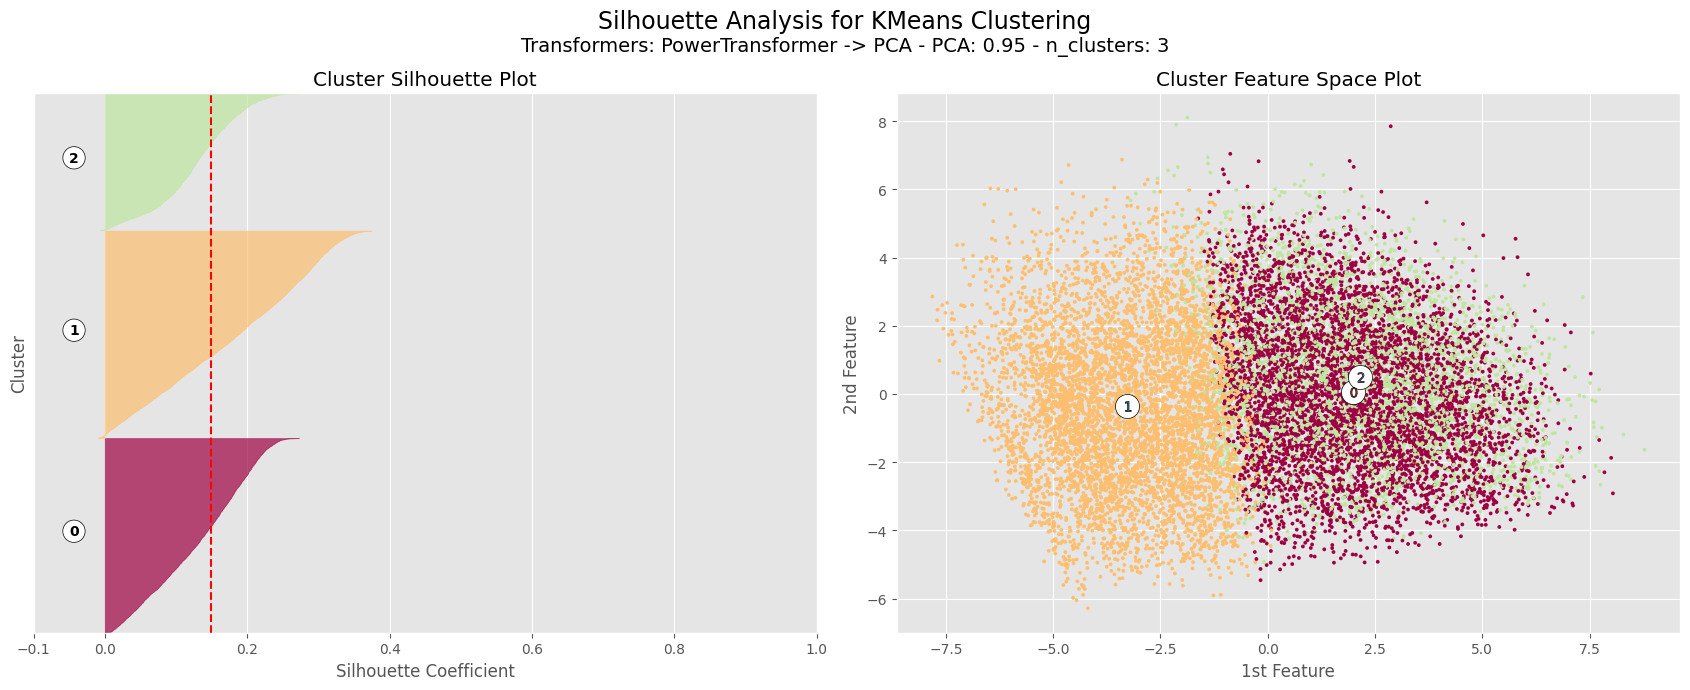

In [ ]:
# Investigate silhouette analysis plot with n_clusters=3
plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 3)

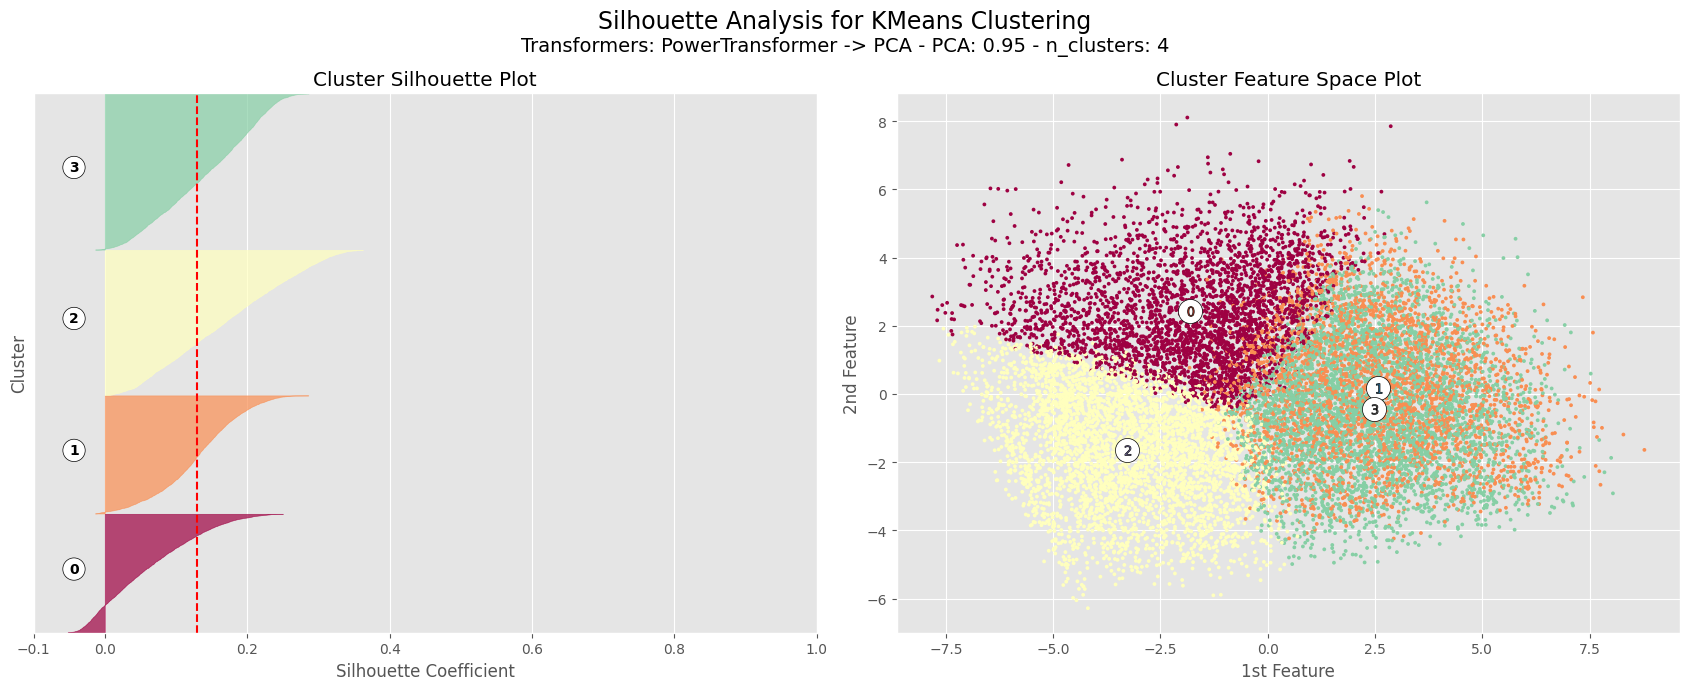

In [ ]:
# Investigate silhouette analysis plot with n_clusters=4
plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 4)

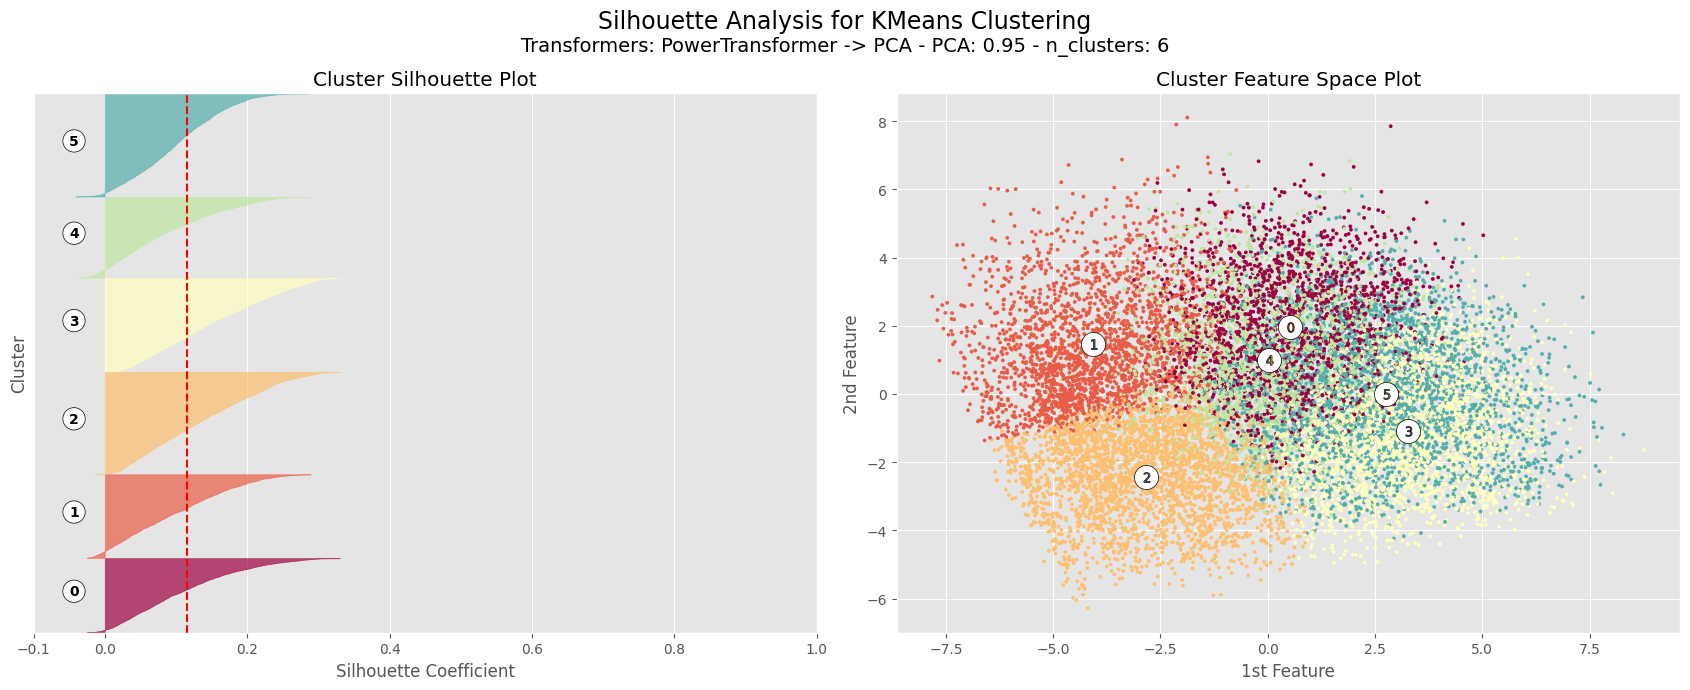

In [ ]:
# Investigate silhouette analysis plot with n_clusters=6
plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 6)

As it can be seen from the graphs above, 2, 6, and to a lesser extent 3 number of clusters seems to the most reasonable choices. The decision here was to go with 6 clusters as a compromise between elbow and shilloutte methods.

## Model Implementation

In [ ]:
# Set desired parameters
n_clusters = 6
ev = 0.95
est = 'KMeans'

# Transform, fit, and predict
X = transform_data(coe, ev)
model, labels = fit_predict_data(X, n_clusters, est)

# Store predicted labels in `coe` dataframe
coe['cluster'] = labels

print(f'{est} with {n_clusters} Clusters\n', 'Silhouette Score: ', np.round(silhouette_score(X, labels), 2))

KMeans with 6 Clusters
 Silhouette Score:  0.11


Again, it is worth noting here that the silhouette score (coefficient) is lower than one would have hoped. This indicates overlapping clusters or the data is not clustrable. Nonetheless, outcome clusters will be investigated below.

In [ ]:
def plot_cluster_analysis(plot, df, target_columns, title, cluster_column='cluster', print_stats=True):
    '''
    Plot using seaborn library target_columns and print descriptive statistics
    grouped by cluster_column to analyse clusters formations

    How to use:
    (1) For plot='countplot'; target_columns is expected to be single str where
        in this case x=cluster_column and hue=target_columns
    (2) For plot='violinplot'; target_columns could be:
        (A) single str where in this case x=cluster_column and y=target_columns
        (B) list of two str(s) where in this case x=cluster_column and
            y=(target_columns[1]/target_columns[0])
    (3) For plot='scatterplot'; target_columns is expected to be list of two str(s)
        where x=target_columns[0] and y=target_columns[1]

    Args:
    plot (str): plot type; 'scatterplot', 'countplot', 'violinplot'
    df (pd.DataFrame): subject dataframe
    target_columns (str, list):
    title (str): plot title/suptitle
    cluster_column (str) [default='cluster'] = column holding cluster labels

    Return:
    None
    '''

    # Create copy of input dataframe to manipulate
    aux_df = df.copy()

    # Assess target_columns is a list
    if (isinstance(target_columns, list)):

        # Define x and y to be used in violinplot or scatterplot
        x, y = target_columns[0], target_columns[1]

        # Perform calculations used in violinplot
        aux_df[title] = (aux_df[y] / aux_df[x]).replace([np.nan, np.inf], 0)
        target_columns = title

    if plot == 'scatterplot':
        # Gte set of clusters labels
        n_clusters = np.unique(df[cluster_column]).tolist()

        # Create subplot with 1 row and len(n_clusters) columns
        fig, ax = plt.subplots(1, len(n_clusters), figsize=(17,5), sharey=True, sharex=True)

        for i in n_clusters:
            # Plot scatterplot for each cluster on its corresponding column axis
            sns.scatterplot(data=df.loc[df[cluster_column]==i], x=x, y=y, ax=ax[i], s=15)
            ax[i].set_title(f'Cluster {i}', size=11)

            # Remove redundant x-labels and y-labels, and
            # Replace them with one lable on each overall axis
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')
            fig.text(0.5, 0.04, x, ha='center', size=11)
            fig.text(0.08, 0.5, y, va='center', rotation='vertical', size=11)

            # Add suptitle
            fig.suptitle(title, size=14)
            fig.subplots_adjust(top=0.86)

    if plot != 'scatterplot':
        plt.figure(figsize=(17,5))

        # Plot according to `plot` input
        if plot == 'countplot':
            sns.countplot(data=aux_df, x=cluster_column, hue=target_columns)
        if plot == 'violinplot':
            sns.violinplot(data=aux_df, x=cluster_column, y=target_columns)

        plt.title(title)
        plt.ylabel('')
        plt.xlabel('Cluster')

    # Prepare descriptive statistics table
    stats = aux_df.groupby(cluster_column)[target_columns].describe().reset_index()
    stats = stats[['cluster', 'mean', 'min', '50%', 'max']]
    stats.rename(columns={'50%': 'median'}, inplace=True)
    stats = np.round(stats, 2)

    # Show outputs
    plt.show()
    if print_stats == True:
        print(stats.to_string(index=False))

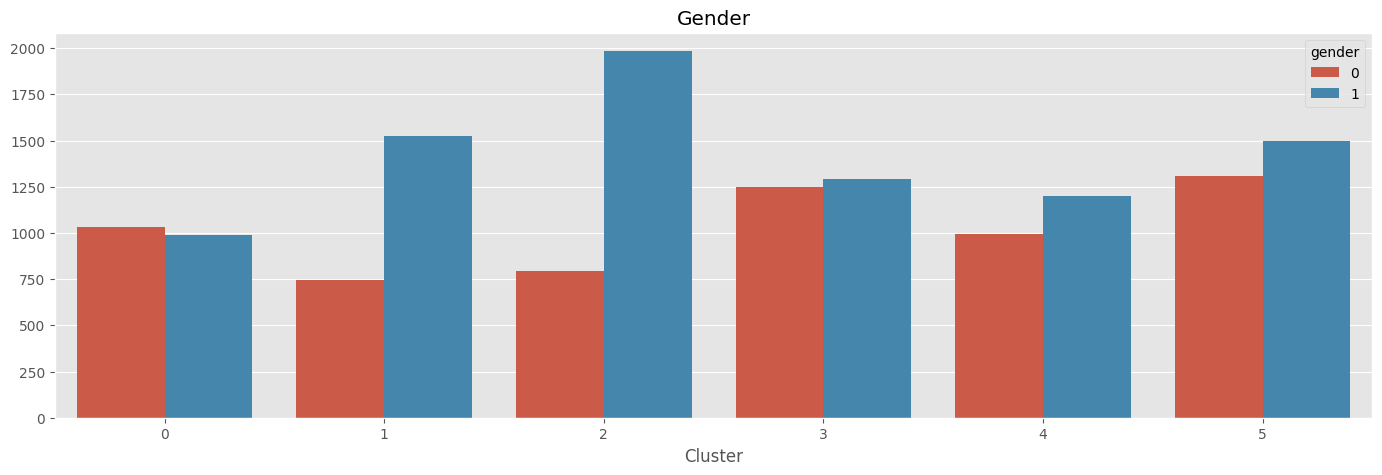

 cluster  mean  min  median  max
       0  0.49  0.0     0.0  1.0
       1  0.67  0.0     1.0  1.0
       2  0.71  0.0     1.0  1.0
       3  0.51  0.0     1.0  1.0
       4  0.55  0.0     1.0  1.0
       5  0.53  0.0     1.0  1.0


In [ ]:
# Investigate `gender` distribution in clusters
plot_cluster_analysis(plot='countplot', df=coe,
                        target_columns='gender',
                        title='Gender')


Column gender is a categorical variable so descriptive statistics in this case are arbitrary, but since females are represented by 0 and males by 1, the mean would tell about gender distrbution in a cluster. If mean is about 0.5 then both genders are equally represented in the cluster which is the case for all clusters except clusters 1 and 2 where males are overrepresented. Overall, the model does a decent job in avoiding clusters formation based on gender type.

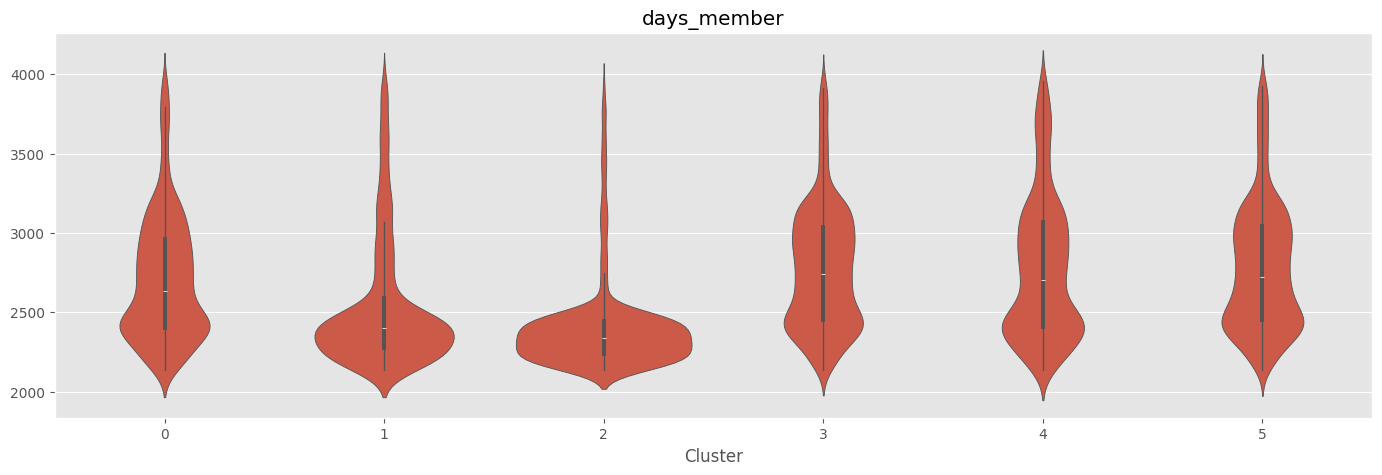

 cluster    mean    min  median    max
       0 2713.61 2139.0  2636.0 3961.0
       1 2534.99 2139.0  2399.0 3961.0
       2 2403.12 2139.0  2338.0 3949.0
       3 2778.60 2139.0  2740.5 3962.0
       4 2780.16 2139.0  2706.5 3958.0
       5 2785.99 2139.0  2725.0 3961.0


In [ ]:
# Investigate `age`
# Choice of violin plot because it depicts the distribution of numerical data for one or more groups.
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='days_member',
                        title='days_member')



The center lines (representing medians) for all clusters are roughly at the same level, around 2700 days. This suggests that the typical number of days a person has been a member is similar across all clusters except 1 and 2.


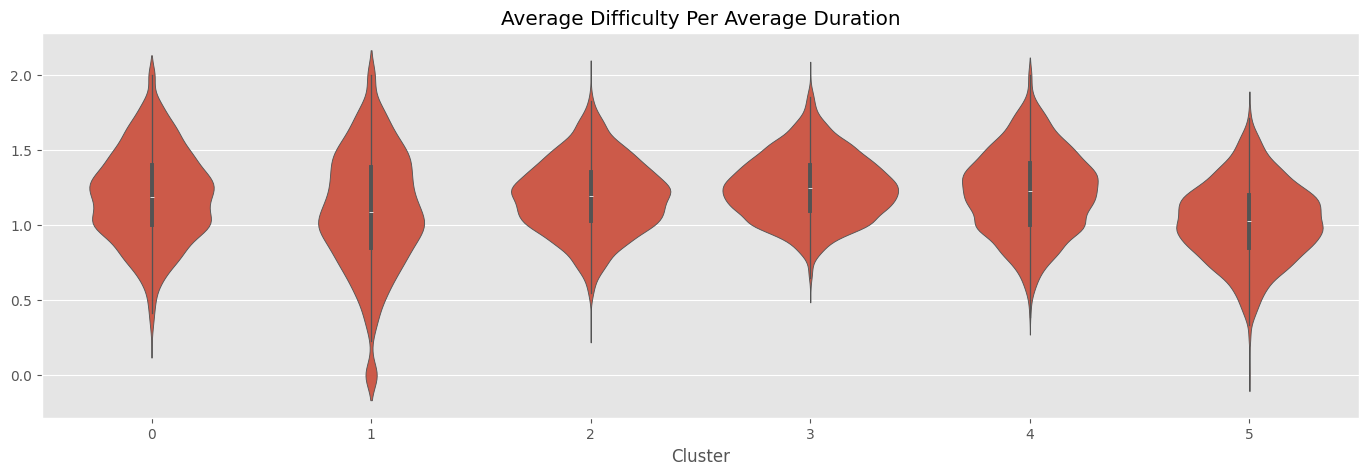

 cluster  mean  min  median  max
       0  1.20 0.25    1.19 2.00
       1  1.10 0.00    1.09 2.00
       2  1.19 0.32    1.19 2.00
       3  1.25 0.58    1.25 2.00
       4  1.22 0.39    1.23 2.00
       5  1.02 0.00    1.03 1.79


In [ ]:
# Investigate average `difficulty` per average `duration`
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['duration', 'difficulty'],
                        title='Average Difficulty Per Average Duration')

Another important metric is to see if all clusters were fairly treated in terms of difficulty of offers received. By calculating the average difficulty per average duration for each customer for all offers received, it can be seen that on average all clusters received a difficulty of about $1 per day in duration.

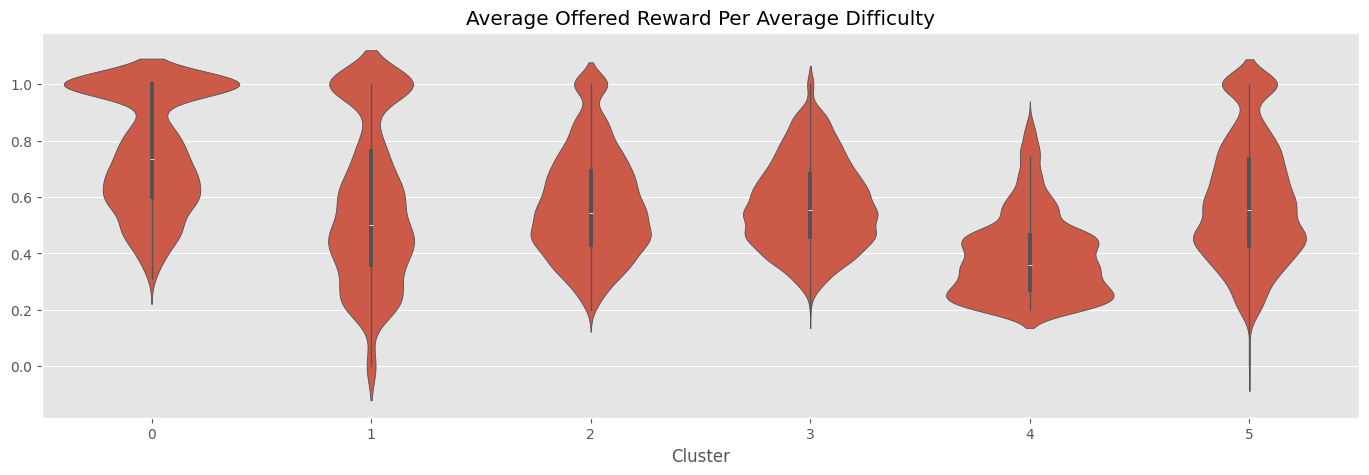

 cluster  mean  min  median  max
       0  0.76 0.31    0.73 1.00
       1  0.58 0.00    0.50 1.00
       2  0.58 0.20    0.54 1.00
       3  0.58 0.20    0.56 1.00
       4  0.39 0.20    0.36 0.88
       5  0.59 0.00    0.56 1.00


In [ ]:
# Investigate average `offered_reward` per average `difficulty`
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['difficulty', 'offered_reward'],
                        title='Average Offered Reward Per Average Difficulty')

Similarly, by calculating the the average reward per average difficulty for each customer for all offers received, it can be seen that cluster 0 enjoys highest rate. That means the company offered to reward customers in this cluster with 76¢ on the dollar assuming the offer is completed. Followed by clusters 1, 2, 3, and 5 with about 60¢ on the dollar. Last comes cluster 4 with about 20¢ on the dollar.

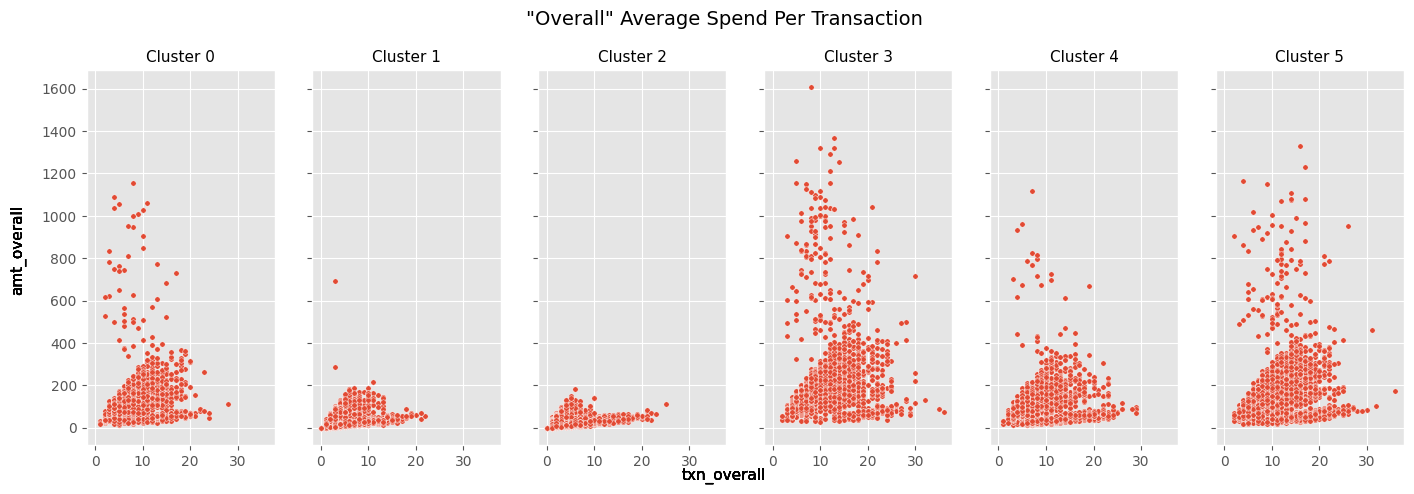

 cluster  mean  min  median    max
       0 19.91 1.67   18.48 307.93
       1  8.60 0.00    3.74 231.27
       2  6.99 0.00    3.33  50.08
       3 21.32 1.60   18.77 301.31
       4 16.27 1.42   16.11 234.63
       5 17.43 1.65   16.04 451.47


In [ ]:
# Investigate "overall" average spend per transaction
plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_overall', 'amt_overall'],
                        title='"Overall" Average Spend Per Transaction')

Looking at amt_overall per txn_overall (average spend per transaction), all clusters exhibit similar numbers except for clusters 4 and 5 with very low numbers. These two clusters are affected by customers who never made any transaction (from now on, will be referred to as "idle customers") as it can be seen from the minimum. Idle customers represent 3.3% and 8.9% in clusters 0 and 1 respectively as confirmed below.

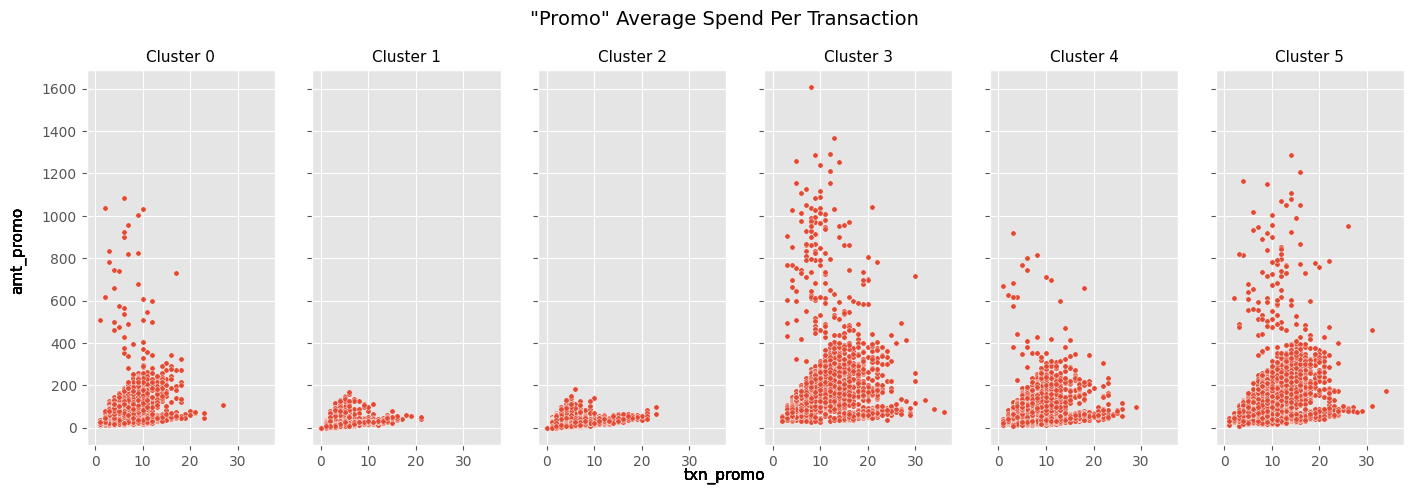

 cluster  mean  min  median    max
       0 19.84 1.74   18.28 518.32
       1  7.49 0.00    3.38  39.22
       2  6.83 0.00    3.29  50.08
       3 21.52 1.60   18.73 301.31
       4 16.67 1.41   16.01 666.86
       5 17.34 1.65   16.02 307.20


In [ ]:
# Investigate "promo" average spend per transaction
plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_promo', 'amt_promo'],
                        title='"Promo" Average Spend Per Transaction')



Since most transactions in the dataset are made during promotion periods, amt_promo per txn_promo tend to project comparable numbers to overall. Again, similar numbers for all clusters except for clusters 4 and 5 with very low numbers.


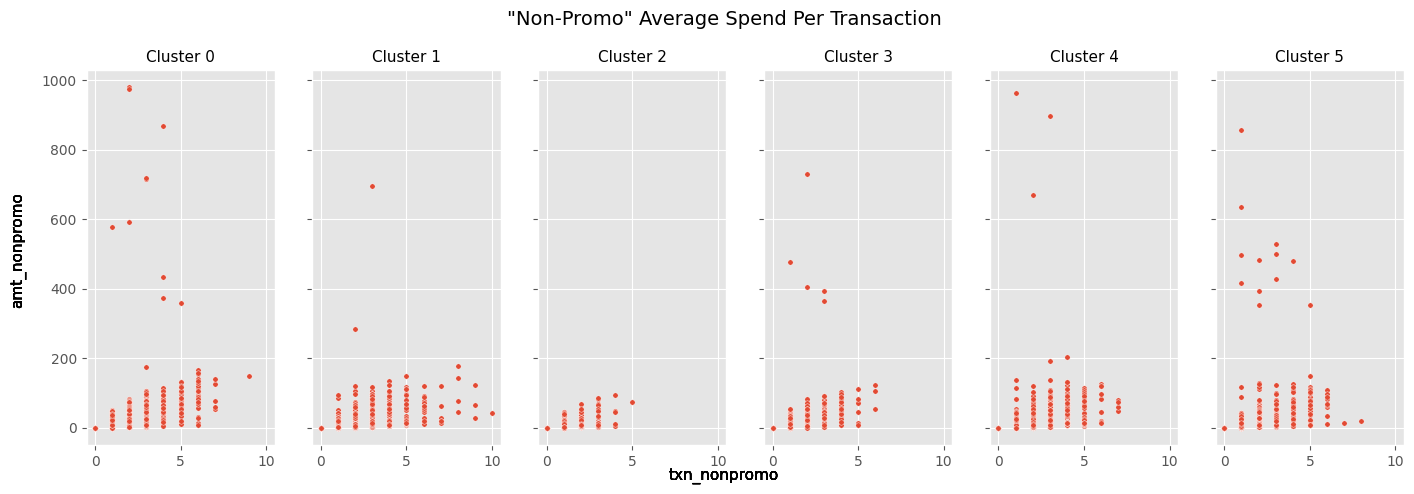

 cluster  mean  min  median    max
       0 15.12  0.0   14.10 576.53
       1  7.20  0.0    3.06 231.27
       2  1.93  0.0    0.00  46.67
       3  6.63  0.0    0.00 476.33
       4 10.51  0.0    5.00 962.10
       5  9.49  0.0    3.12 855.31


In [ ]:
# Investigate "nonpromo" average spend per transaction
plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_nonpromo', 'amt_nonpromo'],
                        title='"Non-Promo" Average Spend Per Transaction')

In amt_nonpromo per txn_nonpromo, significant difference between clusters. Cluster 4 with the highest spend per transaction in non-promotional periods, and followed by cluster 5. In contrast, cluster 2 with a mean of \$1.93 per transaction and a maximum of \$46.67. This starts to indicate which customers are actively spending during non-promotional periods and which customers need to be promoted to do so. All clusters suffer from idle customers but to different degrees as it can be seen below.

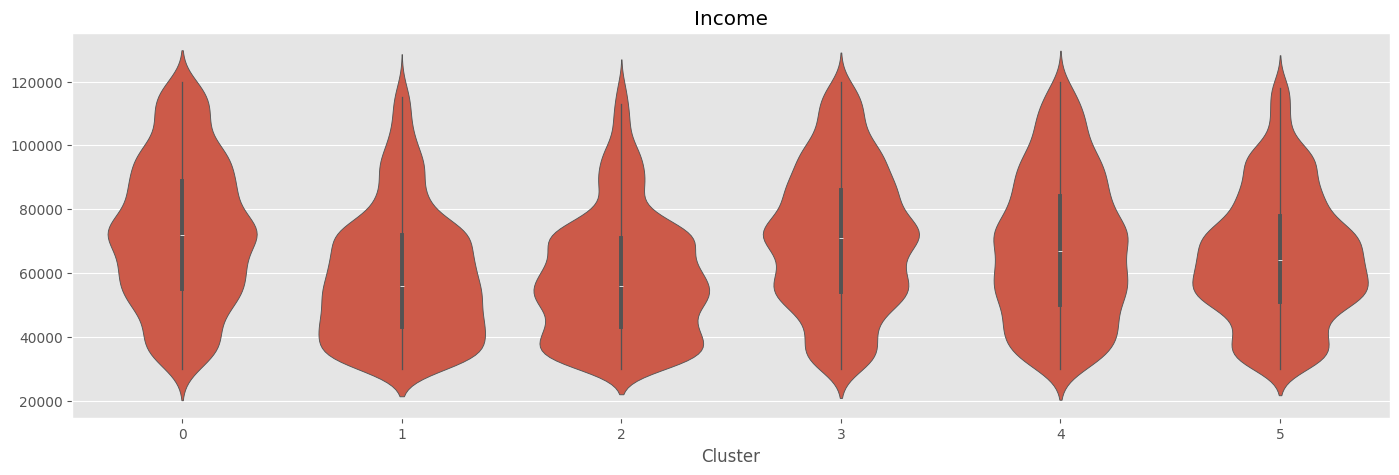

 cluster     mean     min  median      max
       0 72564.92 30000.0 72000.0 120000.0
       1 59111.85 30000.0 56000.0 120000.0
       2 58722.92 30000.0 56000.0 119000.0
       3 70825.73 30000.0 71000.0 120000.0
       4 68108.48 30000.0 67000.0 120000.0
       5 65111.98 30000.0 64000.0 120000.0


In [ ]:
# Investigate `income`
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='income',
                        title='Income')

Investigating income supports the narrative above to some extent. Cluster 0 with the highest mean income of $72,920 explaining their high activity during non-promotional periods. It worth noting cluster 3 which is the second highest income group, but these costumes were one of the lowest active during non-promotional periods and only active if promoted to do so. In contrast, while cluster 2 mean income is low, there are moderately active between the two periods as discussed above.

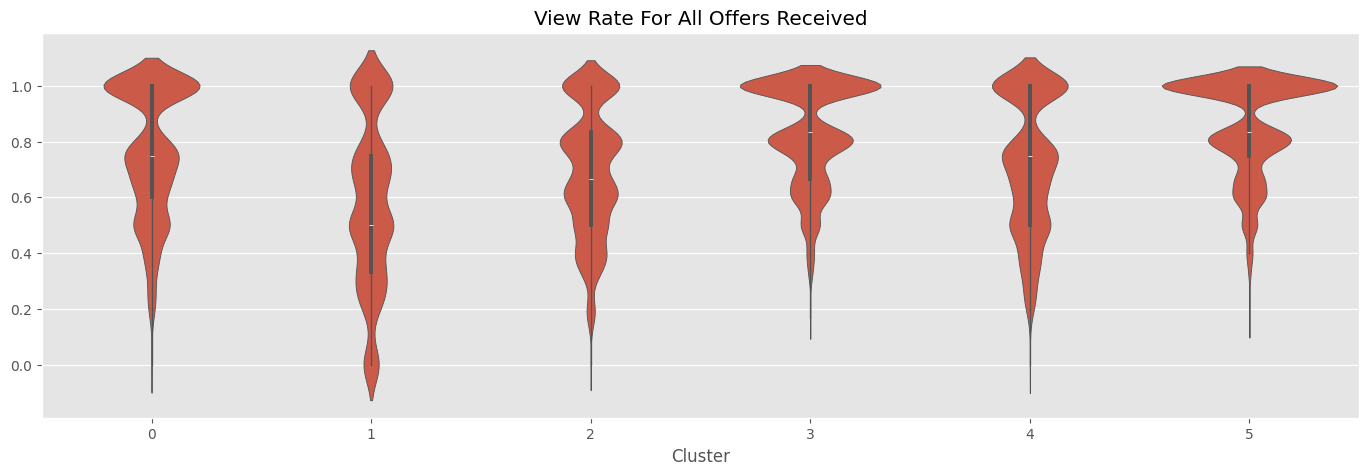

 cluster  mean  min  median  max
       0  0.76 0.00    0.75  1.0
       1  0.58 0.00    0.50  1.0
       2  0.69 0.00    0.67  1.0
       3  0.83 0.17    0.83  1.0
       4  0.71 0.00    0.75  1.0
       5  0.85 0.17    0.83  1.0


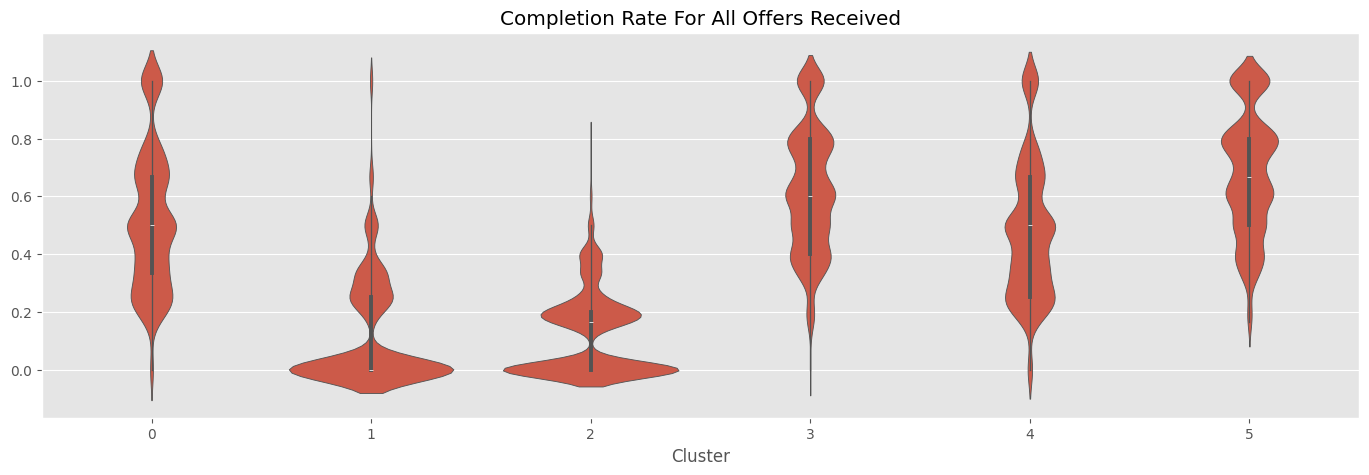

 cluster  mean  min  median  max
       0  0.52 0.00    0.50  1.0
       1  0.12 0.00    0.00  1.0
       2  0.13 0.00    0.17  0.8
       3  0.62 0.00    0.60  1.0
       4  0.47 0.00    0.50  1.0
       5  0.67 0.17    0.67  1.0


In [ ]:
# Investigate viewership and completion rates as percentage of all offers received
for column, title in zip(['offer_viewed', 'offer_completed'], ['View', 'Completion']):
    plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['offer_received', column],
                        title=f'{title} Rate For All Offers Received')

Taking a look at view and completion rates as percentage of all offers received. It can be seen that all clusters have moderate to high view rates, with the lowest being 58% for cluster 1 and the highest being 85% for cluster 5. Completion rates however are 67% and 62% for clusters 5 and 3 respectively, 52% and 47% for clusters 0 and 4 respectively, and badly low 13% and 12% for clusters 2 and 1 respectively.

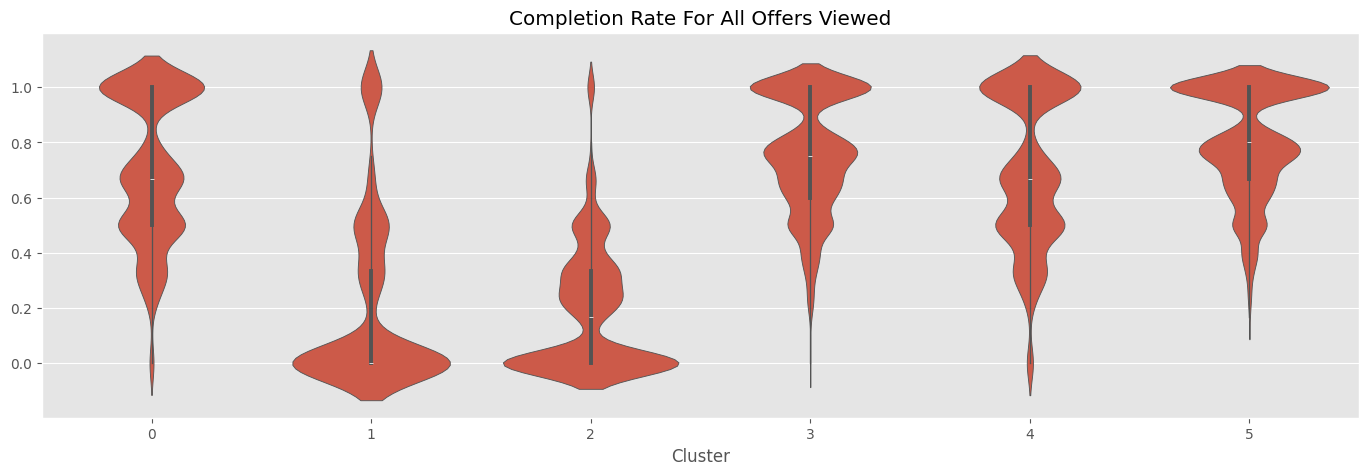

 cluster  mean  min  median  max
       0  0.70 0.00    0.67  1.0
       1  0.21 0.00    0.00  1.0
       2  0.19 0.00    0.17  1.0
       3  0.75 0.00    0.75  1.0
       4  0.69 0.00    0.67  1.0
       5  0.79 0.17    0.80  1.0


In [ ]:
# Investigate completion rates as percentage of all offers viewed
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['offer_viewed', 'offer_completed'],
                        title='Completion Rate For All Offers Viewed')

Looking at completion rate for all offers as a percentage of offers viewed (not received). Clusters 0, 3, 4, and 5 completed around 70-80% of all offers they have viewed. Clusters 1 and 2 only completed about 20% of all offers they have viewed.

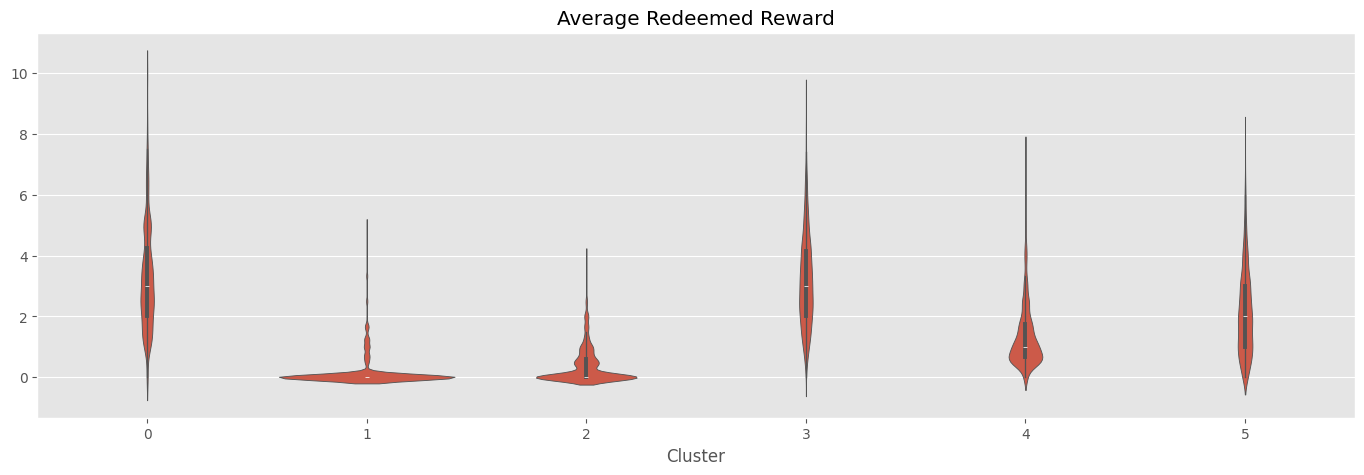

 cluster  mean  min  median   max
       0  3.27  0.0     3.0 10.00
       1  0.16  0.0     0.0  5.00
       2  0.37  0.0     0.0  4.00
       3  3.17  0.0     3.0  9.17
       4  1.33  0.0     1.0  7.50
       5  2.12  0.0     2.0  8.00


In [ ]:
# Investigate average `redeemed_reward`
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='redeemed_reward',
                        title='Average Redeemed Reward')


Looking at average redeemed_reward for all offers completed, clusters 0 and 3 with the highest redeemed rewards of \$3.27 and \$3.17 respectively. Clusters 2 and 1 with the lowest being $0.37 and $0.16 respectively.

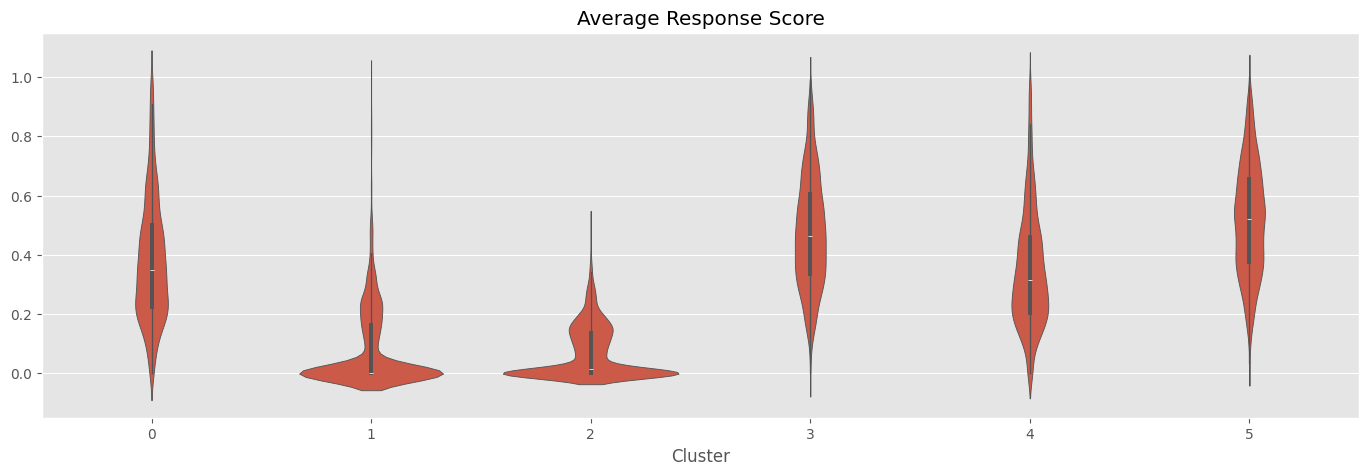

 cluster  mean  min  median  max
       0  0.38 0.00    0.35 1.00
       1  0.08 0.00    0.00 1.00
       2  0.07 0.00    0.01 0.51
       3  0.48 0.00    0.46 0.99
       4  0.35 0.00    0.31 1.00
       5  0.52 0.03    0.52 1.00


In [ ]:
# Investigate average `response_score`
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='response_score',
                        title='Average Response Score')


Looking at response_score, which again measures how fast a customer react to an offer with 2 being fastest, it can be seen that cluster 2 are fastest with 0.52 mean (and median) response score. Followed by cluster 3 with a mean of 0.48 response score. It worth noting cluster 1 and 2 which exhibit a very low mean of 0.08 and 0.07 response score respectively.

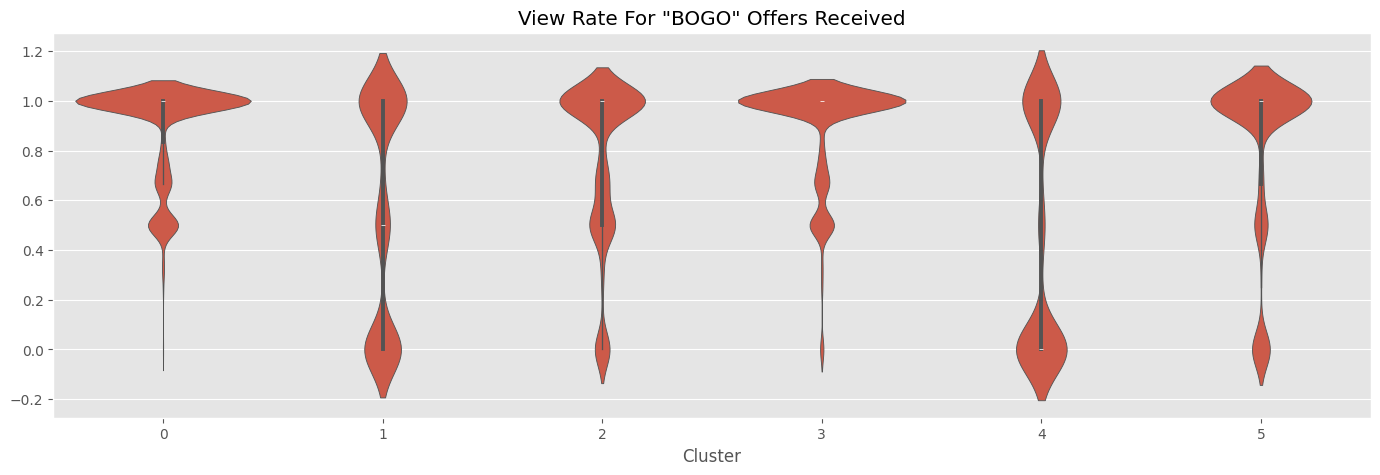

 cluster  mean  min  median  max
       0  0.89  0.0     1.0  1.0
       1  0.56  0.0     0.5  1.0
       2  0.76  0.0     1.0  1.0
       3  0.89  0.0     1.0  1.0
       4  0.44  0.0     0.0  1.0
       5  0.81  0.0     1.0  1.0


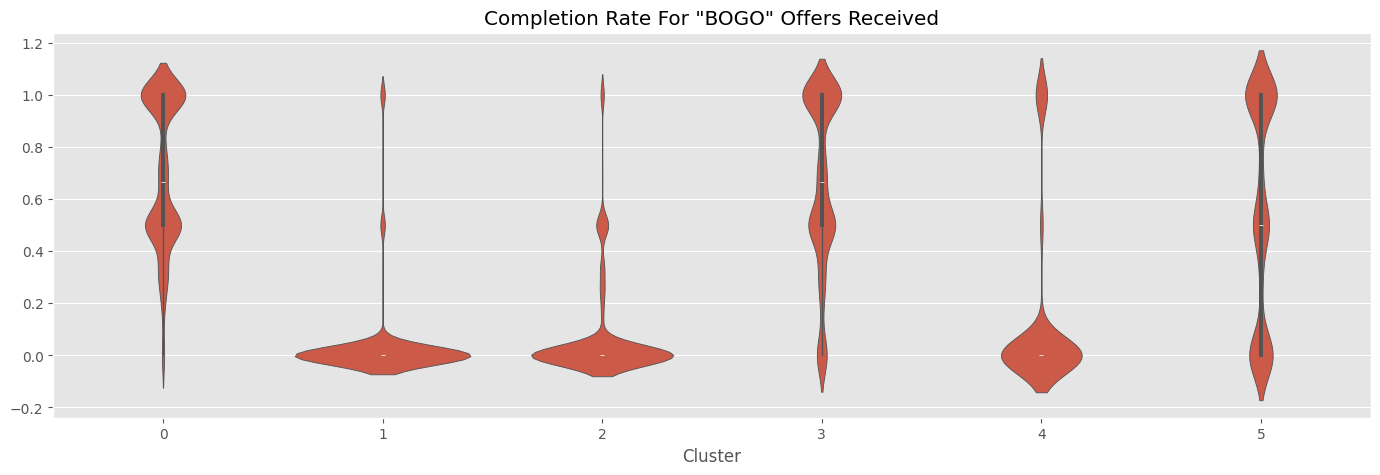

 cluster  mean  min  median  max
       0  0.70  0.0    0.67  1.0
       1  0.04  0.0    0.00  1.0
       2  0.07  0.0    0.00  1.0
       3  0.66  0.0    0.67  1.0
       4  0.13  0.0    0.00  1.0
       5  0.55  0.0    0.50  1.0


In [ ]:
# Investigate viewership and completion rates as percentage of "bogo" offers received
for column, title in zip(['bogo_offer_viewed', 'bogo_offer_completed'], ['View', 'Completion']):
    plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['bogo_offer_received', column],
                        title=f'{title} Rate For "BOGO" Offers Received')

Looking at view and completion rates for "bogo" offers, all clusters have relatively high view rate with the lowest being 44% for cluster 4 but completion rates varies. Actually, clusters 0, 3, and 5 have 80-90% view rates and 55-70% completion rates indicating these clusters do in fact like "bogo" offers. For clusters 1 and 2, view rates are around 55-75% but completion rates are severely low with 4% and 7% respectively which leads to the assumtion that these customers might feel indifferent towards "bogo" offers. Similar argument can be made regarding cluster 4.

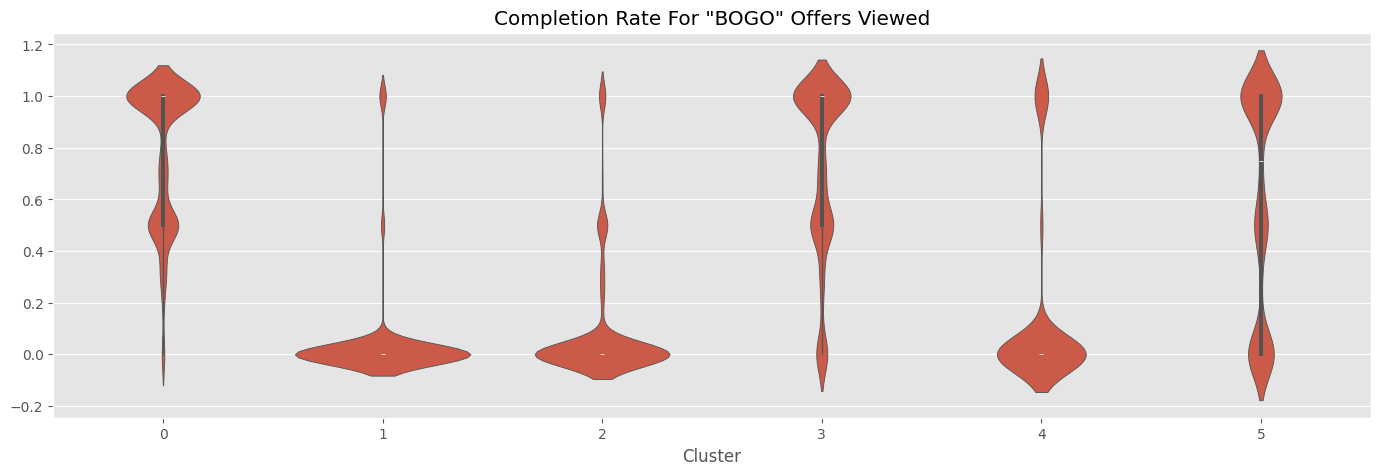

 cluster  mean  min  median  max
       0  0.79  0.0    1.00  1.0
       1  0.04  0.0    0.00  1.0
       2  0.09  0.0    0.00  1.0
       3  0.73  0.0    1.00  1.0
       4  0.14  0.0    0.00  1.0
       5  0.59  0.0    0.75  1.0


In [ ]:
# Investigate completion rates as percentage of "bogo" offers viewed
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['bogo_offer_viewed', 'bogo_offer_completed'],
                        title='Completion Rate For "BOGO" Offers Viewed')

Here, looking at completion rate for "bogo" offers as a percentage of offers viewed. Again, clusters 0, 3, 5 completed 59-79% of all 'bogo' offers they have viewed. Clusters 1, 2, 4 only completed 5-15% of all 'bogo' offers they have viewed.

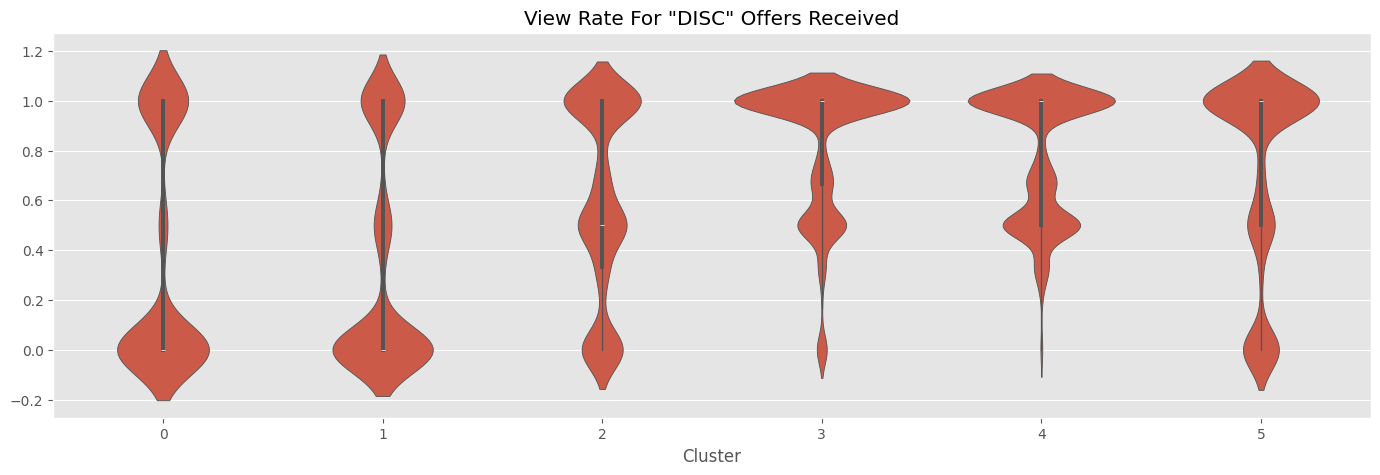

 cluster  mean  min  median  max
       0  0.36  0.0     0.0  1.0
       1  0.33  0.0     0.0  1.0
       2  0.60  0.0     0.5  1.0
       3  0.82  0.0     1.0  1.0
       4  0.77  0.0     1.0  1.0
       5  0.72  0.0     1.0  1.0


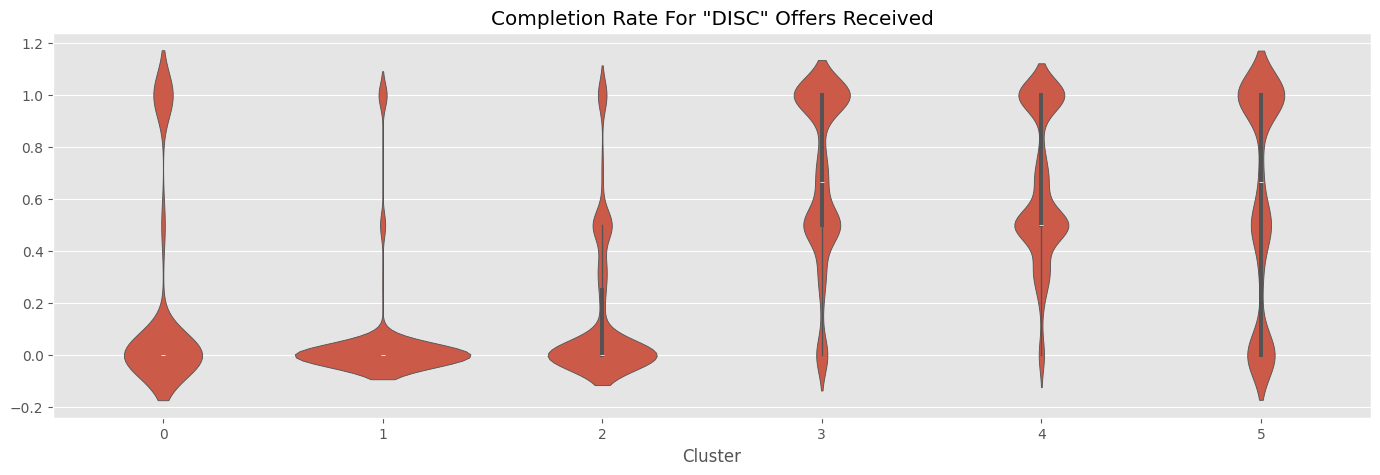

 cluster  mean  min  median  max
       0  0.21  0.0    0.00  1.0
       1  0.06  0.0    0.00  1.0
       2  0.15  0.0    0.00  1.0
       3  0.68  0.0    0.67  1.0
       4  0.64  0.0    0.50  1.0
       5  0.60  0.0    0.67  1.0


In [ ]:
# Investigate viewership and completion rates as percentage of "disc" offers received
for column, title in zip(['disc_offer_viewed', 'disc_offer_completed'], ['View', 'Completion']):
    plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['disc_offer_received', column],
                        title=f'{title} Rate For "DISC" Offers Received')

In similar manner, for "disc" offers, clusters 3, 4, and 5 have view rates around 70-81% and completion rates around 60-67% indicating strong interest in "disc" offers. Clusters 0 and 1 have view rates around 33-38% and completion rates around 6-21%. Seeing cluster 2 while at 58% view rate is only at 15% completion rate suggests no interest in 'disc" offers.


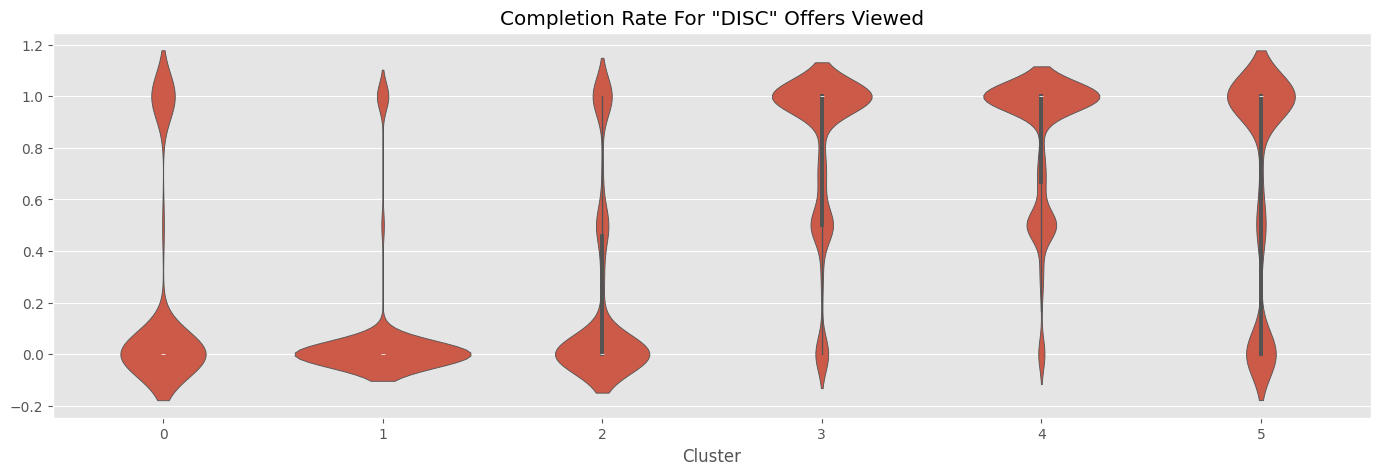

 cluster  mean  min  median  max
       0  0.22  0.0     0.0  1.0
       1  0.07  0.0     0.0  1.0
       2  0.21  0.0     0.0  1.0
       3  0.80  0.0     1.0  1.0
       4  0.83  0.0     1.0  1.0
       5  0.68  0.0     1.0  1.0


In [ ]:
# Investigate completion rates as percentage of "disc" offers viewed
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['disc_offer_viewed', 'disc_offer_completed'],
                        title='Completion Rate For "DISC" Offers Viewed')

Looking at completion rate for "disc" offers as percentage of offers viewed. Again, clusters 3, 4, 5 completed around 68-83% of all 'disc' offers they have viewed. It worth noting, cluster 0 while previously not interested in "bogo" offers are now leading "disc" completion rates with 83%. Clusters 0, 1, and 2 only completed 7-22% of all 'disc' offers they have viewed (cluster 0 was leading completion rates for "bogo" offers).

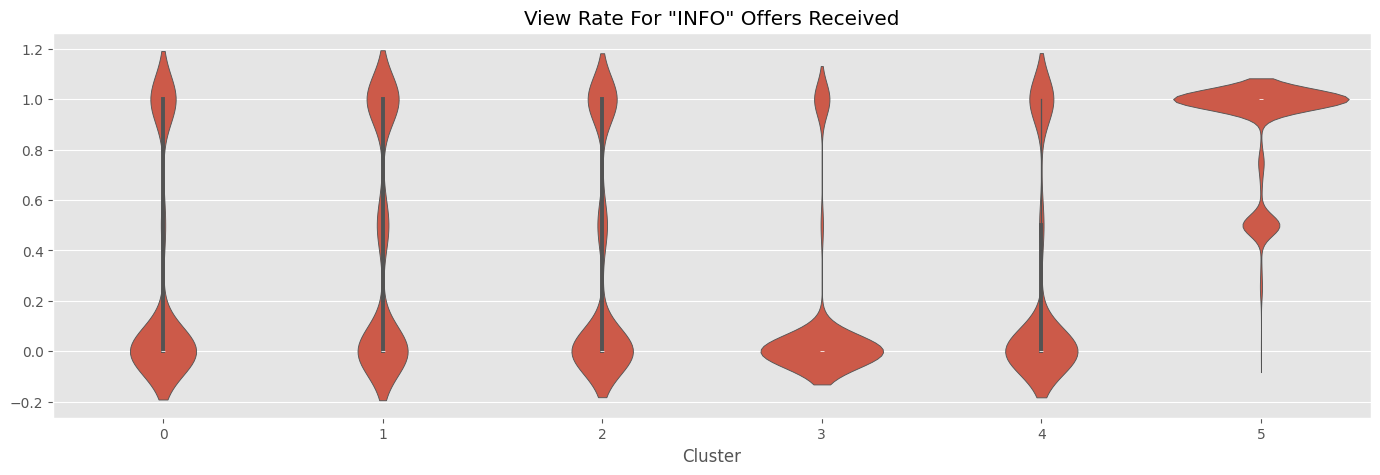

 cluster  mean  min  median  max
       0  0.29  0.0     0.0  1.0
       1  0.41  0.0     0.0  1.0
       2  0.34  0.0     0.0  1.0
       3  0.12  0.0     0.0  1.0
       4  0.26  0.0     0.0  1.0
       5  0.90  0.0     1.0  1.0


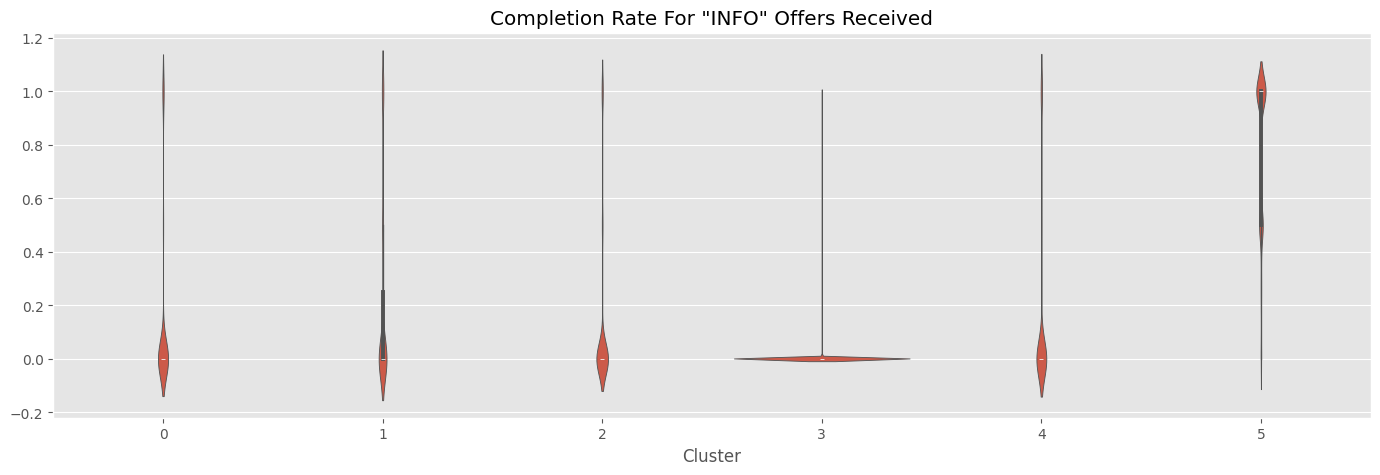

 cluster  mean  min  median  max
       0  0.12  0.0     0.0  1.0
       1  0.20  0.0     0.0  1.0
       2  0.11  0.0     0.0  1.0
       3  0.00  0.0     0.0  1.0
       4  0.13  0.0     0.0  1.0
       5  0.81  0.0     1.0  1.0


In [ ]:
# Investigate viewership and completion rates as percentage of "info" offers received
for column, title in zip(['info_offer_viewed', 'info_offer_completed'], ['View', 'Completion']):
    plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['info_offer_received', column],
                        title=f'{title} Rate For "INFO" Offers Received')

Understandably, reactivity to "info" offers is not the same as "bogo" or "disc. However, worth noting cluster 5 which has 90% view rate and 81% completion rate for all "info" offers they have received. This cluster reacts preferably to "info" offers. Remaining clusters are low to moderate view and completion rates with cluster 3 in specific at 12% view rate and 0% completion rate.

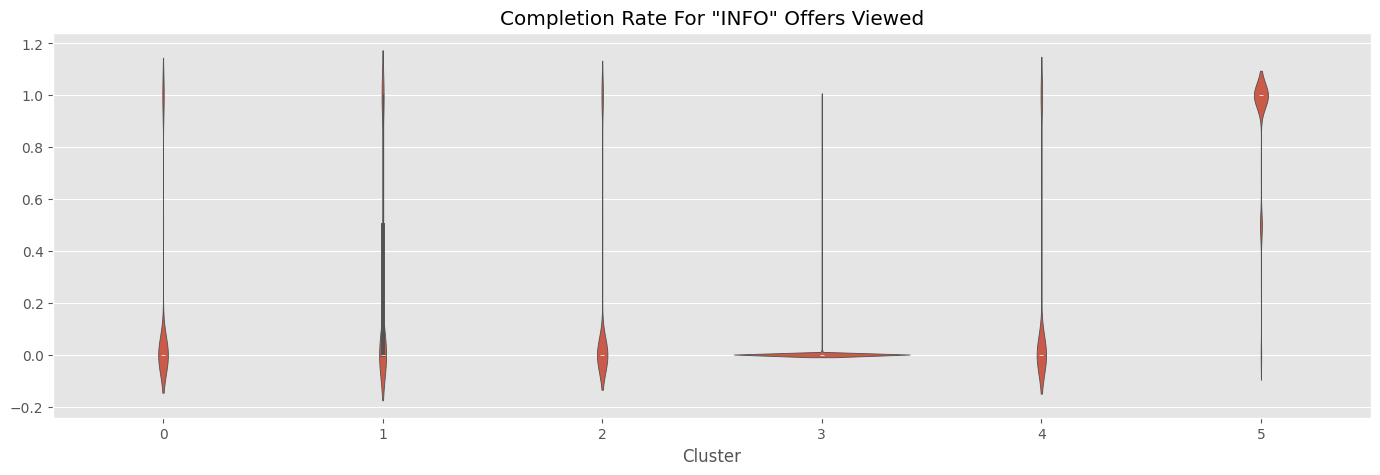

 cluster  mean  min  median  max
       0  0.13  0.0     0.0  1.0
       1  0.23  0.0     0.0  1.0
       2  0.13  0.0     0.0  1.0
       3  0.00  0.0     0.0  1.0
       4  0.14  0.0     0.0  1.0
       5  0.90  0.0     1.0  1.0


In [ ]:
# Investigate completion rates as percentage of "info" offers viewed
plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['info_offer_viewed', 'info_offer_completed'],
                        title='Completion Rate For "INFO" Offers Viewed')

Looking at completion rate for "info" offers as percentage of offers viewed. Again, clusters 5 off the charts with 90% completion of all 'info' offers they have viewed. Remaining clusters are about average 10-20% completion rate except cluster 3 with 0% completion rate.

## Model Recommendations

In [ ]:
# Create dataframe for important metrics to make recommendations
# according to the main two themes discussed in "problem statement"
reco = pd.DataFrame()

# Get relevant data; collected individually for convenient
# ordering, renaming, and computing of features on the go

reco['cluster'] = coe.cluster
reco['income'] = coe.income
reco['seniority'] = coe.days_member
reco['response'] = coe.response_score
reco['atv_nonpromo'] = coe.amt_nonpromo / coe.txn_nonpromo
reco['atv_promo'] = coe.amt_promo / coe.txn_promo
reco['view_bogo'] = coe.bogo_offer_viewed / coe.bogo_offer_received
reco['view_disc'] = coe.disc_offer_viewed / coe.disc_offer_received
reco['view_info'] = coe.info_offer_viewed / coe.info_offer_received
reco['complete_bogo'] = coe.bogo_offer_completed / coe.bogo_offer_viewed
reco['complete_disc'] = coe.disc_offer_completed / coe.disc_offer_viewed
reco['complete_info'] = coe.info_offer_completed / coe.info_offer_viewed

# Groupby `cluster` and aggregate by mean
reco = reco.groupby('cluster').mean()

# Normalize data feature-wise; this allows to plot
# a heatmap representing marks among formed clusters
reco = pd.DataFrame(MinMaxScaler().fit_transform(reco),
                   columns=reco.columns, index=reco.index)

**Nomenclature:**

income: average income

seniority: average days as a member of the program

response: average response score

**Prefixes**

atv_: average transaction value

view_: view rate of offer received

complete_: completion rate of offer viewed

**Suffixes**

_promo: in promotional periods

_nonpromo: in non-promotional periods

_bogo: "buy one get one" offer type

_disc: "discount" offer type

_info: "informational" offer type

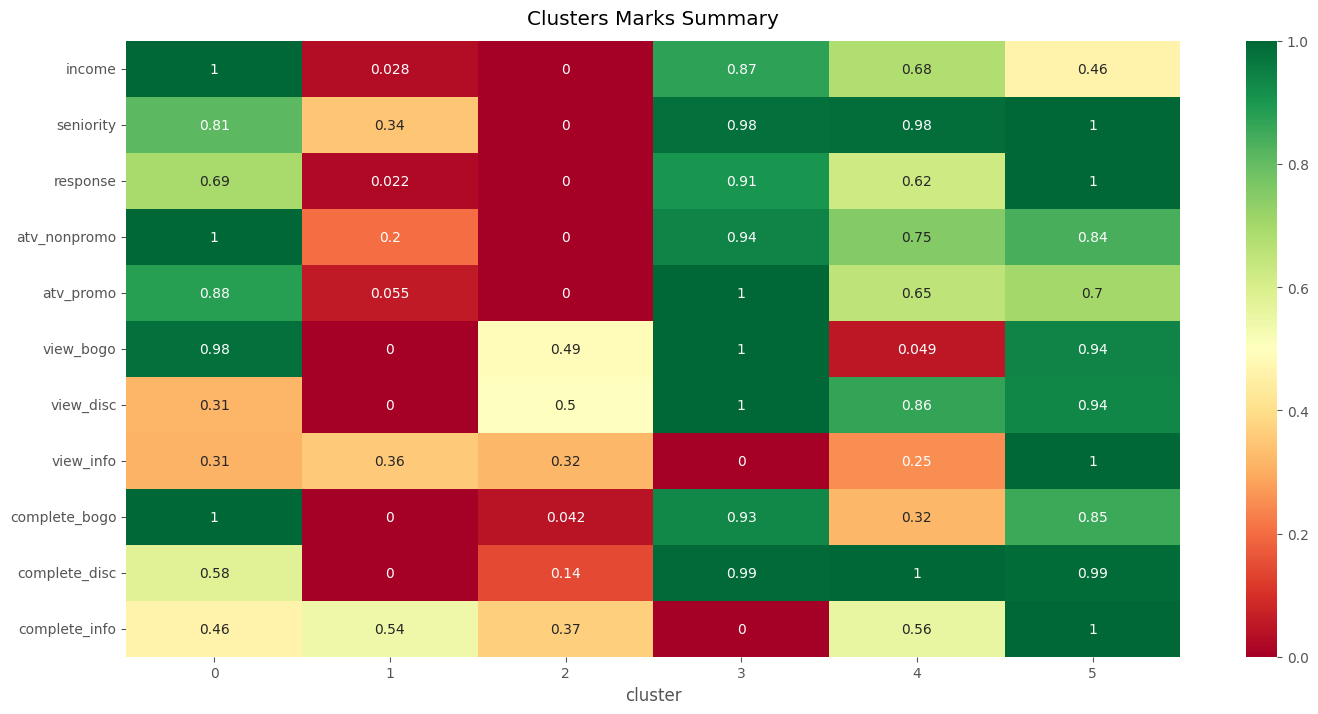

In [ ]:
# Plot heatmap
fig = plt.figure(figsize=(17,8))
fig = sns.heatmap(reco.T, annot=True, cmap='RdYlGn')
fig.set_title('Clusters Marks Summary', pad=12)
fig.set_ylim(len(reco.T), 0)
plt.show()